In [2]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from math import log10, floor, pow, e, sqrt

from functions import *

In [3]:
'''Import Data Links'''
import_path = "./Cleaned Data/"
import_path_raw = "./Raw Data/"
fig_savepath = '../Figures/canopyInteractionFigs/'

In [4]:
'''Colors'''
pal = sns.color_palette('GnBu', 5)
pal

#Figure style
plt.style.use('seaborn-paper')

## Import and Setup

In [5]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv(import_path + 'VegData_LAI_Snow.csv')

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "/ATM/WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

In [6]:
#Retrofit one veg data outlier
#Stake S234 -- labelled all bog trees at dominant when they probably should have been codominant
forestInv.loc[18,  'Co'] = [20]
forestInv.loc[18,  'Dom'] = [0]
forestInv[forestInv.Stake_ID == 'S234']

,Stake_ID,X,Zone,X..Sky.Area,X..Mask.Area,X..Cnpy.Open,X..Site.Open,LAI.4Ring,LAI.5Ring,Watershed,...,BIOMASS,Co,Dom,Int,Sup,prop_Deciduous,prop_Coniferous,WATERSHED,avg_depths,max_depths
18,S234,19,Bog,99.89,0.11,28.49,28.49,1.0725,1.195,S2,...,1571.487612,20,0,6,0,0.0,1.0,S2,39.6875,70.0


In [7]:
'''Organize all data into one data frame'''
#Remove rows on allSnow containing NaNs (these are grid locations where data was not taken)
allSnow_nan = allSnow_df.dropna(how = 'any')

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

#Take average snow depth per site
avgSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed'])['depths'].mean().reset_index()
avgSnow = avgSnow.rename(columns = {'depths' : 'meanDepth'})

#Add in other columns aggregated by year, joined on stakes
## LAI
lai_sub = lai_df[['Stake_ID', 'OLS Prediction Ring 5']]
peakData = pd.merge(peakSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

avgData = pd.merge(avgSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

## Veg Survey
veg_sub = forestInv[['Stake_ID', 'DIST_M', 'DBH_CM', 'DIST_M_SD', 'DBH_CM_SD', 'n', 'basalArea_m2', 'Co', 'Dom', 'Int', 'Sup', 'prop_Coniferous']]
peakData = pd.merge(peakData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

avgData = pd.merge(avgData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

In [8]:
'''Import Melt Data'''
melt = pd.read_csv(import_path + 'snowMeltRates.csv')
melt.head()

,stakes,northing,easting,zones,aspect,slope,watershed,MaxDate_mod,firstSnow_mod,lastSnow_mod,accumulate_mod,melt_mod,MaxDate_meas,firstSnow_meas,lastSnow_meas,accumulate_meas,melt_meas
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-24,2022-12-02 00:00:00,2024-02-15 00:00:00,112 days,328 days
1,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-24,2022-12-02 00:00:00,2024-02-15 00:00:00,112 days,328 days
2,S202,464819.0,5262344.0,Upland,352.4059,2.166370,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-17,2022-12-30 00:00:00,2024-02-15 00:00:00,77 days,335 days
3,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-31,2022-12-02 00:00:00,2024-02-15 00:00:00,119 days,321 days
4,S204,464819.0,5262448.0,Upland,254.4066,9.503919,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-17,2022-12-30 00:00:00,2024-02-15 00:00:00,77 days,335 days


In [9]:
#Merge Data with other descriptors for analysis
meltData = pd.merge(melt[['stakes', 'MaxDate_meas', 'firstSnow_meas', 'lastSnow_meas', 'accumulate_meas', 'melt_meas']],
                    peakData,
                    on = 'stakes')
meltData.columns

Index(['stakes', 'MaxDate_meas', 'firstSnow_meas', 'lastSnow_meas',
       'accumulate_meas', 'melt_meas', 'northing', 'easting', 'zones',
       'aspect', 'slope', 'watershed', 'maxDepth', 'lai5ring', 'avgDist_m',
       'avgDBH_cm', 'sdDist_m', 'sdDBH_cm', 'nTrees', 'basalArea_m2', 'nCo',
       'nDom', 'nInt', 'nSup', 'pCon'],
      dtype='object')

In [10]:
#Remove 'days' text from columns
meltData['melt_meas'] = [int(a[0:-4]) for a in meltData.melt_meas]
meltData['accumulate_meas'] = [int(a[0:-4]) for a in meltData.accumulate_meas]

In [11]:
'''Set PCA Data'''
#Switch this depending on average/maximum snow depth considerations
pca_data = peakData

#remove strings
pca_data_forplot = pca_data.drop(columns = ['stakes', 'zones', 'watershed'])

#remove depths 
pca_data = pca_data_forplot.drop(columns = 'maxDepth')

In [12]:
pca_data.head()

,northing,easting,aspect,slope,lai5ring,avgDist_m,avgDBH_cm,sdDist_m,sdDBH_cm,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,464819.0,5262240.0,193.3626,6.632267,0.380709,5.354320,20.983333,1.290040,7.624701,12,4.651855,7,2,3,0,0.000000
1,464819.0,5262292.0,115.0966,3.120716,0.403804,4.480560,24.216667,1.604152,11.569547,18,10.077594,9,3,6,0,0.111111
2,464819.0,5262396.0,135.0012,7.452870,1.373774,5.025390,14.543750,1.841889,3.984632,16,2.845013,11,3,2,0,0.437500
3,464819.0,5262448.0,254.4066,9.503919,1.750984,5.486400,19.135000,1.786932,5.055302,20,6.132624,16,0,4,0,0.650000
4,464819.0,5262500.0,355.2919,3.051387,0.778448,5.614851,23.850000,1.514223,14.286613,14,8.338256,3,4,4,3,0.142857


## LAI Analysis

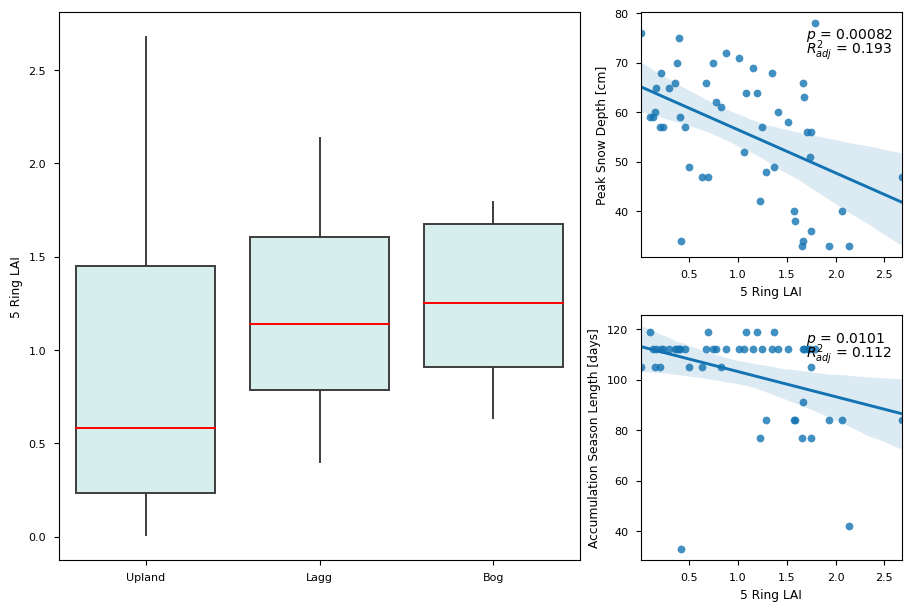

In [13]:
fig = plt.figure(layout = "constrained", figsize = (9, 6))

gs = GridSpec(2, 3, figure = fig)
ax = fig.add_subplot(gs[0:2, 0:2])
sns.boxplot(data = peakData, x = 'zones', y = 'lai5ring',
    notch=False, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": [0.4795847750865052, 0.7984621299500193, 0.7695501730103806, 0.3]},
    medianprops={"color": "red"},
    ax = ax)
ax.set_xlabel(' ')
ax.set_ylabel('5 Ring LAI')

ax2 = fig.add_subplot(gs[0, 2])
sns.regplot(data = peakData, x = 'lai5ring', y = 'maxDepth', color = pal[4])
results = smf.ols('maxDepth ~ lai5ring', data = peakData).fit()
ax2.text(1.7, 75, r'$ p $ = ' + str(round_sig(results.pvalues.lai5ring, 3)))
ax2.text(1.7, 72, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax2.set_xlabel('5 Ring LAI')
ax2.set_ylabel('Peak Snow Depth [cm]')
ax2.set_xlim(min(peakData.lai5ring), max(peakData.lai5ring))

ax3 = fig.add_subplot(gs[1, 2])
sns.regplot(data = meltData, x = 'lai5ring', y = 'accumulate_meas', color = pal[4])
results2 = smf.ols('accumulate_meas ~ lai5ring', data = meltData).fit()
ax3.text(1.7, 115, r'$ p $ = ' + str(round_sig(results2.pvalues.lai5ring, 3)))
ax3.text(1.7, 109, r'$ R_{adj}^2 $ = ' + str(round_sig(results2.rsquared_adj, 3)))

ax3.set_xlabel('5 Ring LAI')
ax3.set_ylabel('Accumulation Season Length [days]')
ax3.set_xlim(min(meltData.lai5ring), max(meltData.lai5ring))

plt.savefig(fig_savepath + 'laicorplot_boxplot.pdf', bbox_inches = 'tight')



## Principle Component Analysis

In [14]:
'''Principle Component Analysis to Determine Snow Controls'''
#Standardize Data
scaler = StandardScaler()
scaler.fit(pca_data)
pca_data_scaled = scaler.transform(pca_data)
#Convert back to dataframe
pca_scaled = pd.DataFrame(data = pca_data_scaled, 
                            columns = pca_data.columns)


In [15]:
pca_scaled.head()

,northing,easting,aspect,slope,lai5ring,avgDist_m,avgDBH_cm,sdDist_m,sdDBH_cm,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,1.849643,-1.201287,0.147365,0.326056,-1.005747,0.460653,0.462296,-1.632968,0.247573,-0.595224,-0.223636,-0.619642,0.436436,-0.132527,-0.573105,-1.380173
1,1.849643,-1.020997,-0.635011,-0.273271,-0.970471,-1.198747,1.225059,-0.789059,1.338819,0.161417,1.741685,-0.286501,1.118367,0.814095,-0.573105,-1.082135
2,1.849643,-0.660417,-0.436038,0.466111,0.511104,-0.164034,-1.056841,-0.150345,-0.759363,-0.090797,-0.878113,0.046640,1.118367,-0.448068,-0.573105,-0.206649
3,1.849643,-0.480126,0.757584,0.816170,1.087272,0.711492,0.026263,-0.297995,-0.463188,0.413630,0.312731,0.879492,-0.927426,0.183014,-0.573105,0.363348
4,1.849643,-0.299836,1.766071,-0.285104,-0.398222,0.955440,1.138560,-1.030667,2.090429,-0.343010,1.111659,-1.285924,1.800298,0.183014,0.836169,-0.996982


In [16]:
#Run PCA
pca = PCA(n_components = 10) #adjustable
pca.fit_transform(pca_data_scaled)

#Extract variance values
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

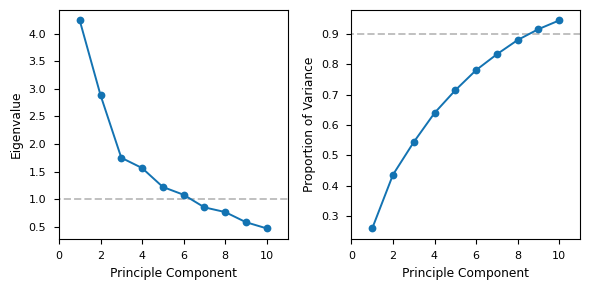

In [17]:
#Scree Plot
PCnumbers = np.arange(pca.n_components_) + 1

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (6, 3), 
                              sharex = True, 
                              tight_layout = True)

ax.plot(PCnumbers, 
         eigenvalues, 
         'o-',
         color = pal[4])
ax.hlines(1, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('Principle Component')

ax2.plot(PCnumbers, 
         np.cumsum(prop_var), 
         'o-', 
         color = pal[4])
ax2.hlines(0.90, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)

ax2.set_ylabel('Proportion of Variance')
ax2.set_xlabel('Principle Component')

ax.set_xlim(0, 11)
plt.savefig(fig_savepath + 'PCAeigenvalues.pdf', bbox_inches = 'tight')
plt.show()
#Using Kaiser's rule we keep all principle components with eigenvalues above 1 and rerun (here 5)

In [18]:
#Rerun PCA
pca2 = PCA(n_components = 5) #adjustable
pc = pca2.fit_transform(pca_data_scaled)

pca_snow = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_snow.head()

,PC1,PC2,PC3,PC4,PC5
0,2.218373,0.546700,1.761302,1.001182,0.435904
1,1.706302,1.987550,0.840318,1.240829,-0.914231
2,0.517243,-1.535036,0.884199,0.212008,-0.342734
3,-0.860334,-0.413097,1.727219,0.756048,-0.487700
4,1.866748,2.443764,0.232156,3.365198,0.097377


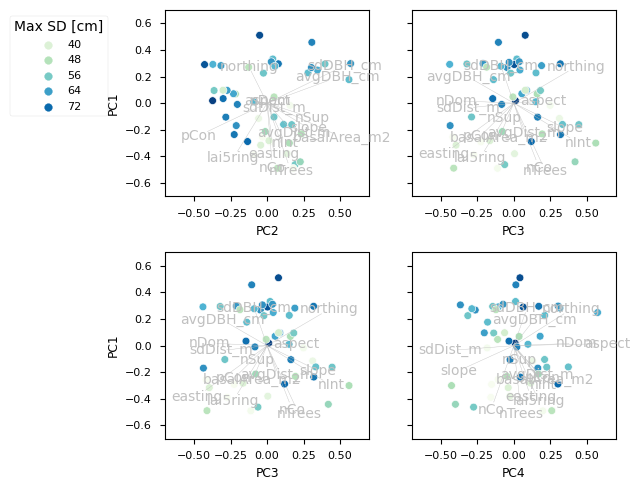

In [19]:
'''BiPlot'''
def biplot(ax, data, score, coef, ipca1, ipca2, labels=None, leg=None):
 
    xs = score[:, ipca1]
    ys = score[:, ipca2]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    sns.scatterplot(x = xs * scalex, y = ys * scaley, 
                hue = data.maxDepth, 
                ax = ax,
                palette = 'GnBu',
                legend = leg)
 
    for i in range(n):
        ax.arrow(0, 0, coef[i, ipca1], 
                  coef[i, ipca2], color = 'silver',
                  alpha = 0.5)
        ax.text(coef[i, ipca1]* 1.15, 
                 coef[i, ipca2] * 1.15, 
                 labels[i], 
                 color = 'silver', 
                 ha = 'center', 
                 va = 'center')
 
    ax.set_xlabel("PC{}".format(ipca1 + 1))
    ax.set_ylabel("PC{}".format(ipca2 + 1)) 

    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)

    #plt.title('Biplot of PCA')   

    #plt.show()

 
fig, axs = plt.subplots(2, 2, figsize = (6.5,5), 
                        tight_layout = True, 
                        sharey = True)
for i in range(0, 2):
    for j in range(0, 2):
        if((i == 0) & (j == 0)):
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns), True)
        else:
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns))

axs[0, 0].legend(title = 'Max SD [cm]', bbox_to_anchor = (-0.25, 1))
plt.savefig(fig_savepath + 'PCAplots.pdf', bbox_inches = 'tight')
plt.show()

### Variable Importance Analysis

In [20]:
#Sort out PCA coefficients
pca_coefs = pd.DataFrame(data = abs(np.transpose(pca2.components_)), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = pca_data.columns)
pca_coefs.head()

,PC1,PC2,PC3,PC4,PC5
northing,0.237948,0.107975,0.370171,0.341288,0.131418
easting,0.334242,0.041062,0.418974,0.100282,0.031133
aspect,0.013584,0.000593,0.173408,0.554034,0.298704
slope,0.163240,0.247047,0.303283,0.326701,0.034335
lai5ring,0.358847,0.200843,0.201530,0.147487,0.106367


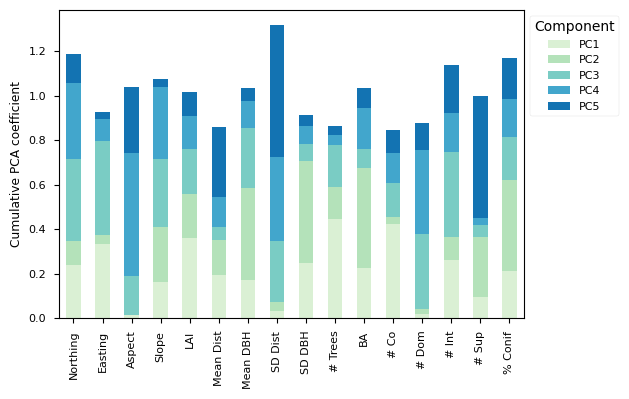

In [21]:
#Variable Importance Plots
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'LAI', 'Mean Dist', 'Mean DBH', 'SD Dist', 'SD DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient')
plt.savefig(fig_savepath + 'PCAcoef.pdf', bbox_inches = 'tight')
plt.show()

In [22]:
#Version weighted by PCA explained percentage
pca_coefs_weighted = pca_coefs
for i in range(0, 5):
    pca_coefs_weighted.iloc[:, i] = pca_coefs_weighted.iloc[:, i]*prop_var[i]

pca_coefs_weighted.head()

,PC1,PC2,PC3,PC4,PC5
northing,0.061774,0.019086,0.039679,0.032695,0.009827
easting,0.086772,0.007258,0.044910,0.009607,0.002328
aspect,0.003526,0.000105,0.018588,0.053076,0.022336
slope,0.042379,0.043669,0.032509,0.031298,0.002567
lai5ring,0.093160,0.035502,0.021602,0.014129,0.007954


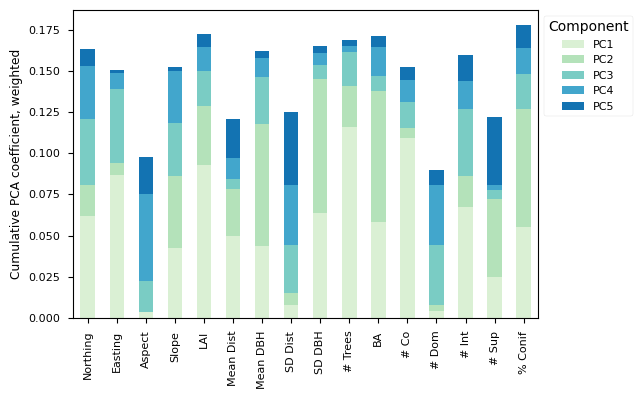

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs_weighted.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'LAI', 'Mean Dist', 'Mean DBH', 'SD Dist', 'SD DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient, weighted')
plt.savefig(fig_savepath + 'PCAcoef-weighted.pdf', bbox_inches = 'tight')
plt.show()

## Random Forest Variable Importance

### Variable Importance for Peak Snow Depth

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

In [25]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(pca_data, pca_data_forplot.maxDepth, test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestRegressor()

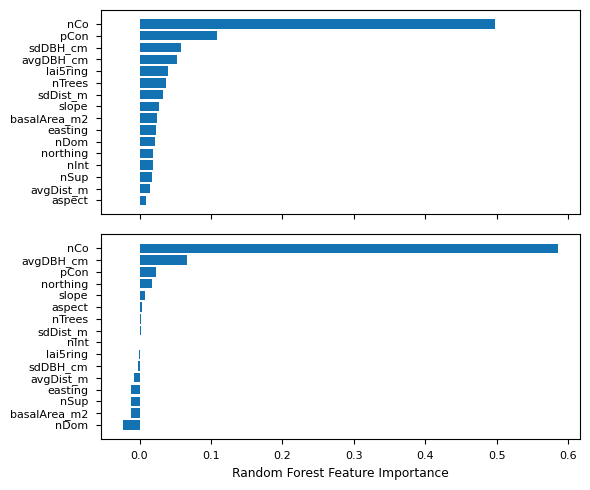

In [26]:
#Sort and plot feature importance
sorted_idx = rf.feature_importances_.argsort()

fig, [ax, ax2] = plt.subplots(2, 1, figsize = (6, 5), 
                              sharex = True, 
                              tight_layout = True)

#Without permutation
ax.barh(pca_data.columns[sorted_idx], rf.feature_importances_[sorted_idx], 
        color = pal[4])
#ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance = permutation_importance(rf, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
ax2.barh(pca_data.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], 
         color = pal[4])
#ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])

ax2.set_xlabel("Random Forest Feature Importance")

plt.savefig(fig_savepath + 'randomForest-importance.pdf', bbox_inches = 'tight')
plt.show()

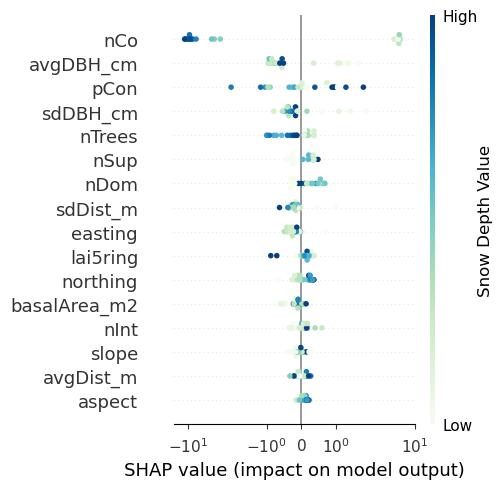

In [27]:
#SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Snow Depth Value', 
                use_log_scale = True, 
                show = False)

plt.savefig(fig_savepath + 'randomForest-SHAP.pdf', bbox_inches = 'tight')

### Analysis by peatland zone

Bog

In [28]:
pca_data_bog = peakData[peakData.zones == 'Bog']

#remove strings
pca_data_forplot_bog = pca_data_bog.drop(columns = ['stakes', 'zones', 'watershed'])

#remove depths 
pca_data_bog = pca_data_forplot_bog.drop(columns = 'maxDepth')


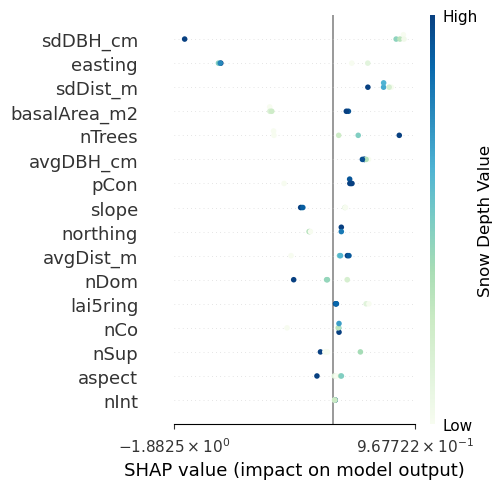

In [29]:
#Split data
X_train_bog, X_test_bog, y_train_bog, y_test_bog = train_test_split(pca_data_bog, pca_data_forplot_bog.maxDepth, test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train_bog, y_train_bog)

#SHAP values
explainer = shap.TreeExplainer(rf)
shap_values_bog = explainer.shap_values(X_test_bog)

shap.summary_plot(shap_values_bog, X_test_bog,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Snow Depth Value', 
                use_log_scale = True, 
                show = False)

plt.savefig(fig_savepath + 'randomForest-SHAP-bog.pdf', bbox_inches = 'tight')

Upland

In [30]:
pca_data_upland = peakData[peakData.zones == 'Upland']

#remove strings
pca_data_forplot_upland = pca_data_upland.drop(columns = ['stakes', 'zones', 'watershed'])

#remove depths 
pca_data_upland = pca_data_forplot_upland.drop(columns = 'maxDepth')


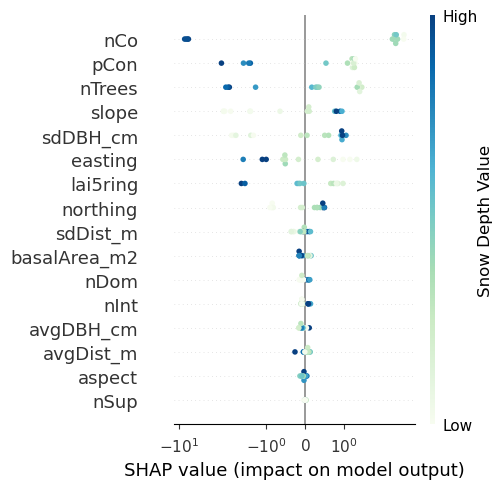

In [31]:
#Split data
X_train_upland, X_test_upland, y_train_upland, y_test_upland = train_test_split(pca_data_upland, pca_data_forplot_upland.maxDepth, test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train_upland, y_train_upland)

#SHAP values
explainer = shap.TreeExplainer(rf)
shap_values_upland = explainer.shap_values(X_test_upland)

shap.summary_plot(shap_values_upland, X_test_upland,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Snow Depth Value', 
                use_log_scale = True, 
                show = False)

plt.savefig(fig_savepath + 'randomForest-SHAP-upland.pdf', bbox_inches = 'tight')

### Repeat Analysis for Snow Melt Rates

In [32]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(pca_data, meltData.melt_meas, test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestRegressor()

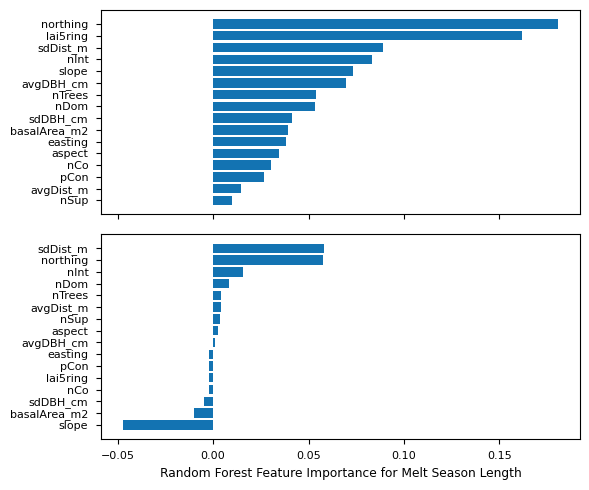

In [33]:
#Sort and plot feature importance
sorted_idx = rf.feature_importances_.argsort()

fig, [ax, ax2] = plt.subplots(2, 1, figsize = (6, 5), 
                              sharex = True, 
                              tight_layout = True)

#Without permutation
ax.barh(pca_data.columns[sorted_idx], rf.feature_importances_[sorted_idx], 
        color = pal[4])
#ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance = permutation_importance(rf, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
ax2.barh(pca_data.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], 
         color = pal[4])
#ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])

ax2.set_xlabel("Random Forest Feature Importance for Melt Season Length")

plt.savefig(fig_savepath + 'randomForest-importance-melt.pdf', bbox_inches = 'tight')
plt.show()

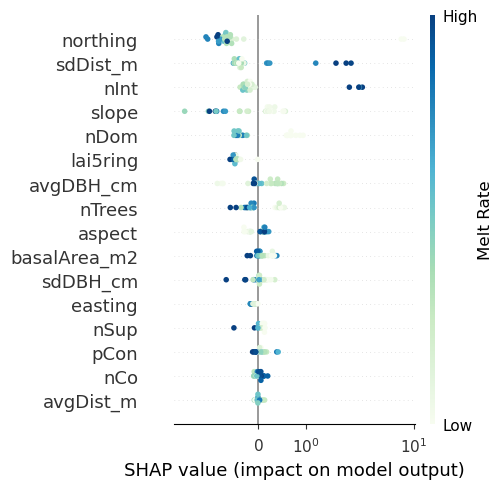

In [34]:
#SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Melt Rate', 
                use_log_scale = True, 
                show = False)

plt.savefig(fig_savepath + 'randomForest-SHAP-melt.pdf', bbox_inches = 'tight')

## Canopy Height Diversity

In [35]:
#Shannon Diversity Index for Canopy Class
def calcH(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc index masking any zeroes
    H = np.sum(pCo*np.log(pCo, where = (pCo != 0)) + 
               pDom*np.log(pDom, where = (pDom != 0)) +
               pInt*np.log(pInt, where = (pInt != 0)) + 
               pSup*np.log(pSup, where = (pSup != 0)))

    return -H

#Hill-Simpson Diversity Index for Canopy Class
def calcS(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc index masking any zeroes
    S = np.sum(pow(pCo, 2) + pow(pDom, 2) + pow(pInt, 2) + pow(pSup, 2))

    return 1/S

#Proportion of co-dominant trees
def calcpCoDom(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot

    return pCo

dd = pca_data_forplot
dd['pCoDom'] = [calcpCoDom(dd.nCo[i], dd.nDom[i], dd.nInt[i], dd.nSup[i]) for i in dd.index]
dd['H'] = [calcH(dd.nCo[i], dd.nDom[i], dd.nInt[i], dd.nSup[i]) for i in dd.index]
dd['S'] = [calcS(dd.nCo[i], dd.nDom[i], dd.nInt[i], dd.nSup[i]) for i in dd.index]

In [36]:
dd.head()

,northing,easting,aspect,slope,maxDepth,lai5ring,avgDist_m,avgDBH_cm,sdDist_m,sdDBH_cm,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon,pCoDom,H,S
0,464819.0,5262240.0,193.3626,6.632267,70.0,0.380709,5.354320,20.983333,1.290040,7.624701,12,4.651855,7,2,3,0,0.000000,0.583333,0.959615,2.322581
1,464819.0,5262292.0,115.0966,3.120716,59.0,0.403804,4.480560,24.216667,1.604152,11.569547,18,10.077594,9,3,6,0,0.111111,0.500000,1.011404,2.571429
2,464819.0,5262396.0,135.0012,7.452870,49.0,1.373774,5.025390,14.543750,1.841889,3.984632,16,2.845013,11,3,2,0,0.437500,0.687500,0.831403,1.910448
3,464819.0,5262448.0,254.4066,9.503919,36.0,1.750984,5.486400,19.135000,1.786932,5.055302,20,6.132624,16,0,4,0,0.650000,0.800000,0.500402,1.470588
4,464819.0,5262500.0,355.2919,3.051387,62.0,0.778448,5.614851,23.850000,1.514223,14.286613,14,8.338256,3,4,4,3,0.142857,0.214286,1.376055,3.920000


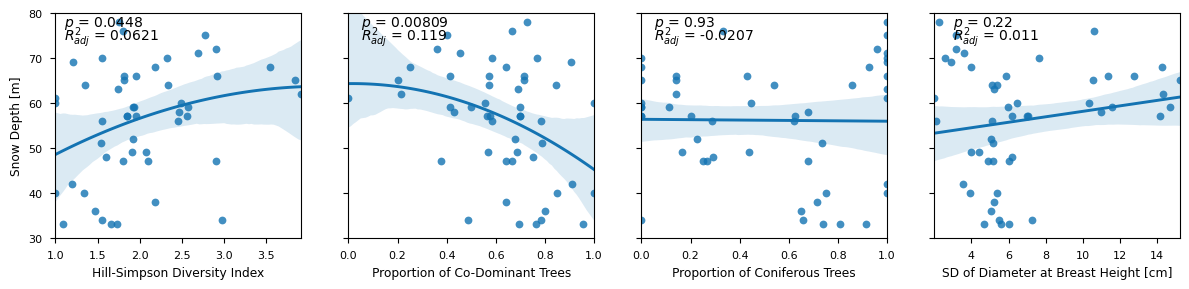

In [37]:
fig, [ax2, ax3, ax4, ax] = plt.subplots(1, 4, figsize = (12, 3), 
                              sharey = True, 
                              tight_layout = True)

sns.regplot(x = dd.S, y = dd.maxDepth, order = 2, ax = ax2, color = pal[4])

#Do regression and add to plot
dd['S2'] = [pow(a, 2) for a in dd.S]
results2 = smf.ols('maxDepth ~ S2', data = dd).fit()
ax2.text(1.1, 77, r'$ p $ = ' + str(round_sig(results2.pvalues.S2, 3)))
ax2.text(1.1, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results2.rsquared_adj, 3)))

ax2.set_xlabel('Hill-Simpson Diversity Index')
ax2.set_ylabel('Snow Depth [m]')
ax2.set_xlim(min(dd.S), max(dd.S))

sns.regplot(x = dd.pCoDom, y = dd.maxDepth, order = 2, ax = ax3, color = pal[4])

#Do regression and add to plot
dd['pCoDom2'] = [pow(a, 2) for a in dd.pCoDom]
results3 = smf.ols('maxDepth ~ pCoDom2', data = dd).fit()
ax3.text(0.05, 77, r'$ p $ = ' + str(round_sig(results3.pvalues.pCoDom2, 3)))
ax3.text(0.05, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results3.rsquared_adj, 3)))

ax3.set_xlabel('Proportion of Co-Dominant Trees')
ax3.set_ylabel(' ')
ax3.set_xlim(min(dd.pCoDom), max(dd.pCoDom))

sns.regplot(x = dd.pCon, y = dd.maxDepth, ax = ax4, color = pal[4])

#Do regression and add to plot
results4 = smf.ols('maxDepth ~ pCon', data = dd).fit()
ax4.text(0.05, 77, r'$ p $ = ' + str(round_sig(results4.pvalues.pCon, 3)))
ax4.text(0.05, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results4.rsquared_adj, 3)))

ax4.set_xlabel('Proportion of Coniferous Trees')
ax4.set_ylabel(' ')
ax4.set_xlim(min(dd.pCon), max(dd.pCon))

sns.regplot(x = dd.sdDBH_cm, y = dd.maxDepth, order = 1, ax = ax, color = pal[4])

#Do regression and add to plot
results = smf.ols('maxDepth ~ sdDBH_cm', data = dd).fit()
ax.text(3, 77, r'$ p $ = ' + str(round_sig(results.pvalues.sdDBH_cm, 3)))
ax.text(3, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax.set_xlabel('SD of Diameter at Breast Height [cm]')
ax.set_ylabel(' ')
ax.set_xlim(min(dd.sdDBH_cm), max(dd.sdDBH_cm))
ax.set_ylim(30, 80)

plt.savefig(fig_savepath + 'DiversityIndex-SnowDepth.pdf', bbox_inches = 'tight')

### Canopy Class Diversity Indicator #1

In [38]:
def calcCCC(co, coConif, dom, domConif, int, intConif, sup, supConif):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc coniferous proportions
    if(co > 0):
        pCoConif = coConif/co
    else:
        pCoConif = 0
    if(dom > 0):
        pDomConif = domConif/dom
    else:
        pDomConif = 0
    if(int > 0):
        pIntConif = intConif/int
    else:
        pIntConif = 0
    if(sup > 0):
        pSupConif = supConif/sup
    else:
        pSupConif = 0

    CCC = np.sum(pCo*np.log(pCo, where = (pCo != 0))*pCoConif + 
               pDom*np.log(pDom, where = (pDom != 0))*pDomConif +
               pInt*np.log(pInt, where = (pInt != 0))*pIntConif + 
               pSup*np.log(pSup, where = (pSup != 0))*pSupConif)


    return -CCC

In [39]:
#Improved Shannon Diversity Metric -- Includes a proportion of each canopy class that is coniferous 

#Numerical Representation of Metric
Sup = []
Int = []
Co = []
Dom = []
SupCon = []
IntCon = []
CoCon = []
DomCon = []
H = []
S = []
CCC = []

#Generate fake data for a site
nTrees = 10

for nSup in np.arange(0, nTrees + 1):
    for nInt in np.arange(0, nTrees + 1 - nSup):
        for nCo in np.arange(0, nTrees + 1 - nSup - nInt):
            nDom = nTrees - nSup - nInt - nCo

            for SupConif in np.arange(0, nSup + 1):
                for IntConif in np.arange(0, nInt + 1):
                    for CoConif in np.arange(0, nCo + 1):
                        for DomConif in np.arange(0, nDom + 1):

                            #Save data
                            Sup.append(nSup)
                            Int.append(nInt)
                            Co.append(nCo)
                            Dom.append(nDom)

                            #Save data
                            SupCon.append(SupConif)
                            IntCon.append(IntConif)
                            CoCon.append(CoConif)
                            DomCon.append(DomConif)

                            #Calculate Shannon Diversity Index
                            H.append(calcH(nCo, nDom, nInt, nSup))
                            #Calculate Hill Simpson Diversity Index
                            S.append(calcS(nCo, nDom, nInt, nSup))
                            #Calculate Coniferous Based Canopy Diversity
                            CCC.append(calcCCC(nCo, CoConif, nDom, DomConif, nInt, IntConif, nSup, SupConif))                       

In [40]:
#Append into dataframe
testData = pd.DataFrame({'Sup' : Sup, 
                         'Int' : Int, 
                         'Co' : Co, 
                         'Dom' : Dom,
                         'SupConif' : SupCon, 
                         'IntConif' : IntCon, 
                         'CoConif' : CoCon, 
                         'DomConif' : DomCon, 
                         'H' : H, 
                         'S' : S, 
                         'CCC' : CCC})

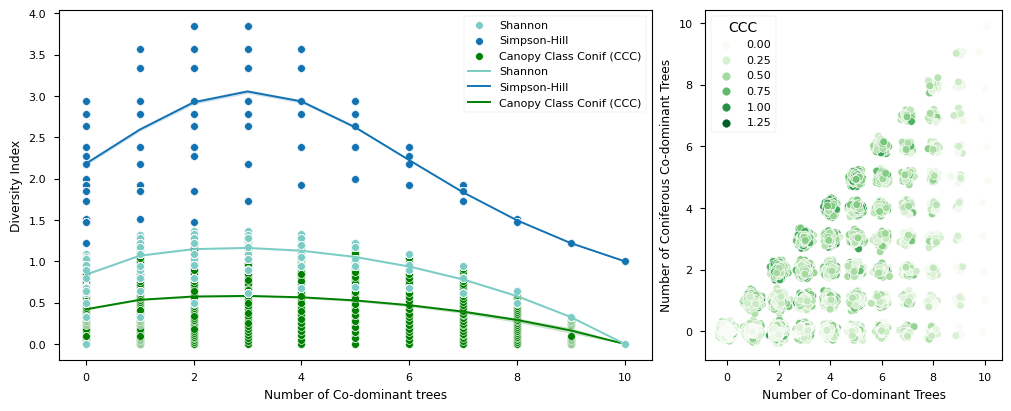

In [41]:
fig = plt.figure(layout="constrained", figsize = (10, 4))

gs = GridSpec(1, 3, figure = fig)
ax = fig.add_subplot(gs[0, 0:2])
sns.scatterplot(data = testData, x = 'Co', y = 'H', ax = ax, label = 'Shannon', zorder = 5, color = pal[2])
sns.scatterplot(data = testData, x = 'Co', y = 'S', ax = ax, label = 'Simpson-Hill', color = pal[4])
sns.scatterplot(data = testData, x = 'Co', y = 'CCC', ax = ax, label = 'Canopy Class Conif (CCC)', color = 'green')
sns.lineplot(data = testData, x = 'Co', y = 'H', ax = ax, label = 'Shannon', zorder = 5, color = pal[2])
sns.lineplot(data = testData, x = 'Co', y = 'S', ax = ax, label = 'Simpson-Hill', color = pal[4])
sns.lineplot(data = testData, x = 'Co', y = 'CCC', ax = ax, label = 'Canopy Class Conif (CCC)', color = 'green')
ax.set_xlabel('Number of Co-dominant trees')
ax.set_ylabel('Diversity Index')

ax2 = fig.add_subplot(gs[0, 2])
sns.scatterplot(x = jitter(testData['Co'], 0), y = jitter(testData['CoConif'], 0), hue = testData['CCC'], palette = 'Greens', ax = ax2)
ax2.set_xlabel('Number of Co-dominant Trees')
ax2.set_ylabel('Number of Coniferous Co-dominant Trees')

plt.savefig(fig_savepath + 'diversityIndex_option1.pdf')

In [42]:
#Complete with real data
#Data set-up

#Import
forestDataS2 = pd.read_excel(import_path + 'S2overstory_2023_compiled.xlsx', 
                             na_values = ['NAN'])
forestDataS6 = pd.read_excel(import_path + 'S6overstory_2023_compiled.xlsx', 
                             na_values = ['NAN'])
forestData = pd.concat([forestDataS2, forestDataS6])
forestData.head()

#Remove Nan rows and strip strings
forestData = forestData.dropna(how = 'any')
forestData['CC'] = [cl.strip() for cl in forestData.CC]

#Label coniferous and deciduous species
forestData['Conif'] = np.where(np.isin(forestData.SPECIES,
                ['Abies balsamea', 'Picea mariana', 'Larix laricina', 'Picea glauca', 'Pinus resinosa', 'Pinus Strobus']),
                'Coniferous', 'Deciduous')

#Sort into zones
forestData['zones'] = np.where(np.isin(forestData.SITE,
                ['S213', 'S221', 'S222', 'S223', 'S233', 'S234', 'S645', 'S634', 'S623', 'S612']), "Bog", 
                np.where(np.isin(forestData.SITE, ['S211', 'S212', 'S224', 'S225', 'S232', 'S235', 'S635', 'S624', 'S613', 'S611', 'S622', 'S633']),
                "Lagg", "Upland"))

#Group by site, canopy class, coniferous
forestData_group = forestData.groupby(['SITE', 'CC', 'Conif'])['SPECIES'].count().reset_index()

#Melt for data to be easier to manage
forestData_melt = forestData_group.pivot(index = 'SITE', columns = ['CC', 'Conif'], values = 'SPECIES')
forestData_melt = forestData_melt.fillna(0)

#Find sums and proportions
fs = forestData_melt
fs['nCo'] = fs['Co', 'Deciduous'] + fs['Co', 'Coniferous']
fs['nDom'] = fs['Dom', 'Deciduous'] + fs['Dom', 'Coniferous']
fs['nInt'] = fs['Int', 'Deciduous'] + fs['Int', 'Coniferous']
fs['nSup'] = fs['Sup', 'Deciduous'] + fs['Sup', 'Coniferous']

#Run diversity index algorithm
fs['CCC'] = [calcCCC(fs.nCo[i], fs['Co', 'Coniferous'][i],
                    fs.nDom[i], fs['Dom', 'Coniferous'][i],
                    fs.nInt[i], fs['Int', 'Coniferous'][i],
                    fs.nSup[i], fs['Sup', 'Coniferous'][i]) for i in range(0, len(fs.nCo))]

fs = fs.reset_index()

fs.head()

CC,SITE,Co,Dom,Int,Co,Int,Sup,Dom,Sup,nCo,nDom,nInt,nSup,CCC
Conif,,Deciduous,Deciduous,Deciduous,Coniferous,Coniferous,Deciduous,Coniferous,Coniferous,,,,,
0,S200,7.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,3.0,0.0,-0.000000
1,S201,7.0,3.0,6.0,2.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,0.0,0.077016
2,S203,6.0,3.0,0.0,5.0,2.0,0.0,0.0,0.0,11.0,3.0,2.0,0.0,0.377022
3,S204,6.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,16.0,0.0,4.0,0.0,0.352987
4,S205,3.0,4.0,2.0,0.0,2.0,3.0,0.0,0.0,3.0,4.0,4.0,3.0,0.178966


In [43]:
#Subset and merge with snow data
diversityOne = pd.merge(peakSnow[['stakes', 'maxDepth', 'watershed']], fs[['CCC', 'SITE']], left_on = 'stakes', right_on = 'SITE')
diversityOne = diversityOne.rename(columns = {diversityOne.columns[3] : 'CCC',
                                            diversityOne.columns[4] : 'SITE'})
diversityOne.head()

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


,stakes,maxDepth,watershed,CCC,SITE
0,S200,70.0,S2,-0.000000,S200
1,S201,59.0,S2,0.077016,S201
2,S203,49.0,S2,0.377022,S203
3,S204,36.0,S2,0.352987,S204
4,S205,62.0,S2,0.178966,S205


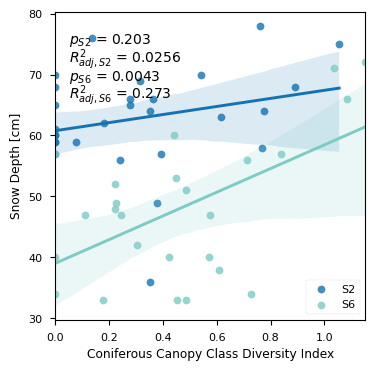

In [44]:
#Real data and Indicator 1 plot
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.regplot(data = diversityOne[diversityOne.watershed == 'S2'], x = 'CCC', y = 'maxDepth',
            ax = ax, color = pal[4], 
            label = 'S2')
sns.regplot(data = diversityOne[diversityOne.watershed == 'S6'], x = 'CCC', y = 'maxDepth',
            ax = ax, color = pal[2], 
            label = 'S6')

#Do regression and add to plot
resultsS2 = smf.ols('maxDepth ~ CCC', data = diversityOne[diversityOne.watershed == 'S2']).fit()
ax.text(0.05, 75, r'$ p_{S2} $ = ' + str(round_sig(resultsS2.pvalues.CCC, 3)))
ax.text(0.05, 72, r'$ R_{adj,S2}^2 $ = ' + str(round_sig(resultsS2.rsquared_adj, 3)))

resultsS6 = smf.ols('maxDepth ~ CCC', data = diversityOne[diversityOne.watershed == 'S6']).fit()
ax.text(0.05, 69, r'$ p_{S6} $ = ' + str(round_sig(resultsS6.pvalues.CCC, 3)))
ax.text(0.05, 66, r'$ R_{adj,S6}^2 $ = ' + str(round_sig(resultsS6.rsquared_adj, 3)))

ax.set_xlabel('Coniferous Canopy Class Diversity Index')
ax.set_ylabel('Snow Depth [cm]')
ax.set_xlim(np.nanmin(diversityOne.CCC), np.nanmax(diversityOne.CCC))

ax.legend()

plt.savefig(fig_savepath + 'DiversityIndex1-SnowDepth.pdf', bbox_inches = 'tight')

### Canopy Class Diversity Indicator #2

In [45]:
def calcCCCa(co, coConif, dom, domConif, int, intConif, sup, supConif):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc coniferout proportions
    if(co > 0):
        pCoConif = coConif/co
    else:
        pCoConif = 0
    if(dom > 0):
        pDomConif = domConif/dom
    else:
        pDomConif = 0
    if(int > 0):
        pIntConif = intConif/int
    else:
        pIntConif = 0
    if(sup > 0):
        pSupConif = supConif/sup
    else:
        pSupConif = 0
    

    CCCa = (pCo*np.log(pCo, where = (pCo != 0))+pCoConif*np.log(pCoConif,
                where = (pCoConif != 0))) + pDom*np.log(pDom, where = (pDom != 0))+pDomConif*np.log(pDomConif,
                where = (pDomConif != 0)) + pInt*np.log(pInt, where = (pInt != 0))+pIntConif*np.log(pIntConif,
                where = (pIntConif != 0)) + pSup*np.log(pSup, where = (pSup != 0))+pSupConif*np.log(pSupConif,
                where = (pSupConif != 0))

    return -CCCa

In [46]:
#Improved Shannon Diversity Metric -- Includes a proportion of each canopy class that is coniferous 

#Numerical Representation of Metric
Sup = []
Int = []
Co = []
Dom = []
SupCon = []
IntCon = []
CoCon = []
DomCon = []
H = []
S = []
CCCa = []

#Generate fake data for a site
nTrees = 10

for nSup in np.arange(0, nTrees + 1):
    for nInt in np.arange(0, nTrees + 1 - nSup):
        for nCo in np.arange(0, nTrees + 1 - nSup - nInt):
            nDom = nTrees - nSup - nInt - nCo

            for SupConif in np.arange(0, nSup + 1):
                for IntConif in np.arange(0, nInt + 1):
                    for CoConif in np.arange(0, nCo + 1):
                        for DomConif in np.arange(0, nDom + 1):

                            #Save data
                            Sup.append(nSup)
                            Int.append(nInt)
                            Co.append(nCo)
                            Dom.append(nDom)

                            #Save data
                            SupCon.append(SupConif)
                            IntCon.append(IntConif)
                            CoCon.append(CoConif)
                            DomCon.append(DomConif)

                            #Calculate Shannon Diversity Index
                            H.append(calcH(nCo, nDom, nInt, nSup))
                            #Calculate Hill Simpson Diversity Index
                            S.append(calcS(nCo, nDom, nInt, nSup))
                            #Calculate Coniferous Based Canopy Diversity
                            CCCa.append(calcCCCa(nCo, CoConif, nDom, DomConif, nInt, IntConif, nSup, SupConif))                       

In [47]:
#Append into dataframe
testData_adapted = pd.DataFrame({'Sup' : Sup, 
                         'Int' : Int, 
                         'Co' : Co, 
                         'Dom' : Dom,
                         'SupConif' : SupCon, 
                         'IntConif' : IntCon, 
                         'CoConif' : CoCon, 
                         'DomConif' : DomCon, 
                         'H' : H, 
                         'S' : S, 
                         'CCCa' : CCCa})

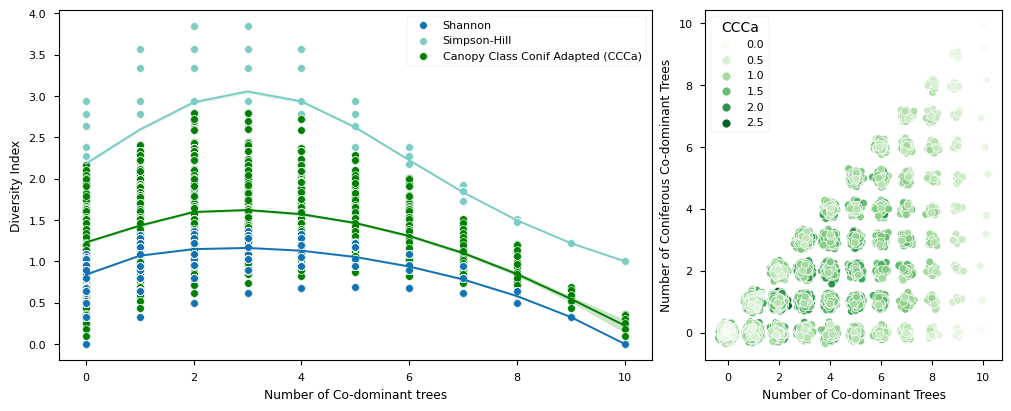

In [48]:
fig = plt.figure(layout="constrained", figsize = (10, 4))

gs = GridSpec(1, 3, figure = fig)
ax = fig.add_subplot(gs[0, 0:2])
sns.scatterplot(data = testData_adapted, x = 'Co', y = 'H', ax = ax, label = 'Shannon', zorder = 5, color = pal[4])
sns.scatterplot(data = testData_adapted, x = 'Co', y = 'S', ax = ax, label = 'Simpson-Hill', color = pal[2])
sns.scatterplot(data = testData_adapted, x = 'Co', y = 'CCCa', ax = ax, label = 'Canopy Class Conif Adapted (CCCa)', color = 'green')
sns.lineplot(data = testData_adapted, x = 'Co', y = 'H', ax = ax, zorder = 5, color = pal[4])
sns.lineplot(data = testData_adapted, x = 'Co', y = 'S', ax = ax, color = pal[2])
sns.lineplot(data = testData_adapted, x = 'Co', y = 'CCCa', ax = ax, color = 'green')
ax.set_xlabel('Number of Co-dominant trees')
ax.set_ylabel('Diversity Index')

ax2 = fig.add_subplot(gs[0, 2])
sns.scatterplot(x = jitter(testData['Co'], 0), y = jitter(testData_adapted['CoConif'], 0), hue = testData_adapted['CCCa'], palette = 'Greens', ax = ax2)
ax2.set_xlabel('Number of Co-dominant Trees')
ax2.set_ylabel('Number of Coniferous Co-dominant Trees')

plt.savefig(fig_savepath + 'diversityIndex_option2.pdf')

In [49]:
#Run diversity index algorithm on real data
fs['CCCa'] = [calcCCCa(fs.nCo[i], fs['Co', 'Coniferous'][i],
                    fs.nDom[i], fs['Dom', 'Coniferous'][i],
                    fs.nInt[i], fs['Int', 'Coniferous'][i],
                    fs.nSup[i], fs['Sup', 'Coniferous'][i]) for i in range(0, len(fs.nCo))]

fs.head()

CC,SITE,Co,Dom,Int,Co,Int,Sup,Dom,Sup,nCo,nDom,nInt,nSup,CCC,CCCa
Conif,,Deciduous,Deciduous,Deciduous,Coniferous,Coniferous,Deciduous,Coniferous,Coniferous,,,,,,
0,S200,7.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,3.0,0.0,-0.000000,0.959615
1,S201,7.0,3.0,6.0,2.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,0.0,0.077016,1.345644
2,S203,6.0,3.0,0.0,5.0,2.0,0.0,0.0,0.0,11.0,3.0,2.0,0.0,0.377022,1.189792
3,S204,6.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,16.0,0.0,4.0,0.0,0.352987,1.009916
4,S205,3.0,4.0,2.0,0.0,2.0,3.0,0.0,0.0,3.0,4.0,4.0,3.0,0.178966,1.722629


In [50]:
#Subset and merge with snow data
diversityTwo = pd.merge(peakSnow[['stakes', 'maxDepth', 'watershed']], fs[['CCCa', 'SITE']], left_on = 'stakes', right_on = 'SITE')
diversityTwo = diversityTwo.rename(columns = {diversityTwo.columns[3] : 'CCCa',
                                            diversityTwo.columns[4] : 'SITE'})
diversityTwo.head()

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


,stakes,maxDepth,watershed,CCCa,SITE
0,S200,70.0,S2,0.959615,S200
1,S201,59.0,S2,1.345644,S201
2,S203,49.0,S2,1.189792,S203
3,S204,36.0,S2,1.009916,S204
4,S205,62.0,S2,1.722629,S205


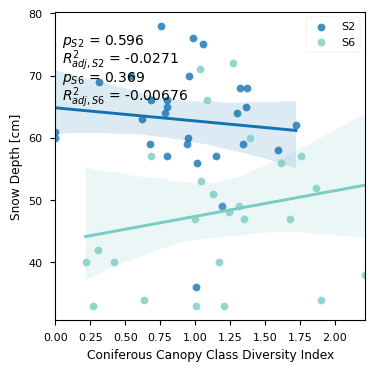

In [51]:
#Real data and Indicator 1 plot
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.regplot(data = diversityTwo[diversityTwo.watershed == 'S2'], x = 'CCCa', y = 'maxDepth',
            ax = ax, color = pal[4], 
            label = 'S2')
sns.regplot(data = diversityTwo[diversityTwo.watershed == 'S6'], x = 'CCCa', y = 'maxDepth',
            ax = ax, color = pal[2], 
            label = 'S6')

#Do regression and add to plot
resultsS2 = smf.ols('maxDepth ~ CCCa', data = diversityTwo[diversityTwo.watershed == 'S2']).fit()
ax.text(0.05, 75, r'$ p_{S2} $ = ' + str(round_sig(resultsS2.pvalues.CCCa, 3)))
ax.text(0.05, 72, r'$ R_{adj,S2}^2 $ = ' + str(round_sig(resultsS2.rsquared_adj, 3)))

resultsS6 = smf.ols('maxDepth ~ CCCa', data = diversityTwo[diversityTwo.watershed == 'S6']).fit()
ax.text(0.05, 69, r'$ p_{S6} $ = ' + str(round_sig(resultsS6.pvalues.CCCa, 3)))
ax.text(0.05, 66, r'$ R_{adj,S6}^2 $ = ' + str(round_sig(resultsS6.rsquared_adj, 3)))

ax.set_xlabel('Coniferous Canopy Class Diversity Index')
ax.set_ylabel('Snow Depth [cm]')
ax.set_xlim(np.nanmin(diversityTwo.CCCa), np.nanmax(diversityTwo.CCCa))

ax.legend()

plt.savefig(fig_savepath + 'DiversityIndex2-SnowDepth.pdf', bbox_inches = 'tight')

In [52]:
'''Data Setup but for Uplands'''
peakSnow_up = peakSnow[peakSnow.zones == 'Upland']

#select upland data
forestData_up = forestData[forestData.zones == 'Upland']

#Group by site, canopy class, coniferous
forestData_up_group = forestData_up.groupby(['SITE', 'CC', 'Conif'])['SPECIES'].count().reset_index()

#Melt for data to be easier to manage
forestData_up_melt = forestData_up_group.pivot(index = 'SITE', columns = ['CC', 'Conif'], values = 'SPECIES')
forestData_up_melt = forestData_up_melt.fillna(0)

#Find sums and proportions
fs_up = forestData_up_melt
fs_up['nCo'] = fs_up['Co', 'Deciduous'] + fs_up['Co', 'Coniferous']
fs_up['nDom'] = fs_up['Dom', 'Deciduous'] + fs_up['Dom', 'Coniferous']
fs_up['nInt'] = fs_up['Int', 'Deciduous'] + fs_up['Int', 'Coniferous']
fs_up['nSup'] = fs_up['Sup', 'Deciduous'] + fs_up['Sup', 'Coniferous']

#Run diversity index algorithm
fs_up['CCC'] = [calcCCC(fs_up.nCo[i], fs_up['Co', 'Coniferous'][i],
                    fs_up.nDom[i], fs_up['Dom', 'Coniferous'][i],
                    fs_up.nInt[i], fs_up['Int', 'Coniferous'][i],
                    fs_up.nSup[i], fs_up['Sup', 'Coniferous'][i]) for i in range(0, len(fs_up.nCo))]

fs_up = fs_up.reset_index()

fs_up.head()

CC     SITE        Co       Dom       Int         Co        Int       Sup  \
Conif       Deciduous Deciduous Deciduous Coniferous Coniferous Deciduous   
0      S200       7.0       2.0       3.0        0.0        0.0       0.0   
1      S201       7.0       3.0       6.0        2.0        0.0       0.0   
2      S203       6.0       3.0       0.0        5.0        2.0       0.0   
3      S204       6.0       0.0       1.0       10.0        3.0       0.0   
4      S205       3.0       4.0       2.0        0.0        2.0       3.0   

CC                      Dom   nCo nDom nInt nSup       CCC  
Conif Coniferous Coniferous                                 
0            0.0        0.0   7.0  2.0  3.0  0.0 -0.000000  
1            0.0        0.0   9.0  3.0  6.0  0.0  0.077016  
2            0.0        0.0  11.0  3.0  2.0  0.0  0.377022  
3            0.0        0.0  16.0  0.0  4.0  0.0  0.352987  
4            0.0        0.0   3.0  4.0  4.0  3.0  0.178966

In [53]:
#Run diversity index algorithm on real data
fs_up['CCCa'] = [calcCCCa(fs_up.nCo[i], fs_up['Co', 'Coniferous'][i],
                    fs_up.nDom[i], fs_up['Dom', 'Coniferous'][i],
                    fs_up.nInt[i], fs_up['Int', 'Coniferous'][i],
                    fs_up.nSup[i], fs_up['Sup', 'Coniferous'][i]) for i in range(0, len(fs_up.nCo))]

fs_up.head()

CC     SITE        Co       Dom       Int         Co        Int       Sup  \
Conif       Deciduous Deciduous Deciduous Coniferous Coniferous Deciduous   
0      S200       7.0       2.0       3.0        0.0        0.0       0.0   
1      S201       7.0       3.0       6.0        2.0        0.0       0.0   
2      S203       6.0       3.0       0.0        5.0        2.0       0.0   
3      S204       6.0       0.0       1.0       10.0        3.0       0.0   
4      S205       3.0       4.0       2.0        0.0        2.0       3.0   

CC                      Dom   nCo nDom nInt nSup       CCC      CCCa  
Conif Coniferous Coniferous                                           
0            0.0        0.0   7.0  2.0  3.0  0.0 -0.000000  0.959615  
1            0.0        0.0   9.0  3.0  6.0  0.0  0.077016  1.345644  
2            0.0        0.0  11.0  3.0  2.0  0.0  0.377022  1.189792  
3            0.0        0.0  16.0  0.0  4.0  0.0  0.352987  1.009916  
4            0.0        0.0   3.0  4.0  4.0  3.0  0.178966  1.722629

In [54]:
#Subset and merge with snow data
diversityTwo_up = pd.merge(peakSnow_up[['stakes', 'maxDepth', 'watershed']], fs_up[['CCCa', 'SITE']], left_on = 'stakes', right_on = 'SITE', how = 'inner')
diversityTwo_up = diversityTwo_up.rename(columns = {diversityTwo_up.columns[3] : 'CCCa',
                                            diversityTwo_up.columns[4] : 'SITE'})
diversityTwo_up.head()

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


,stakes,maxDepth,watershed,CCCa,SITE
0,S200,70.0,S2,0.959615,S200
1,S201,59.0,S2,1.345644,S201
2,S203,49.0,S2,1.189792,S203
3,S204,36.0,S2,1.009916,S204
4,S205,62.0,S2,1.722629,S205


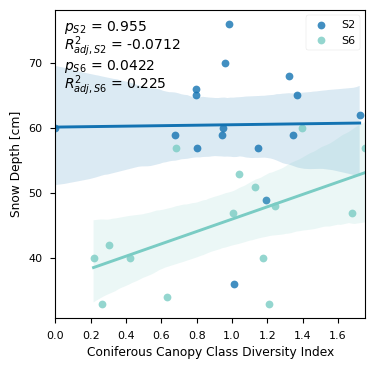

In [55]:
#Real data and Indicator 1 plot
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.regplot(data = diversityTwo_up[diversityTwo_up.watershed == 'S2'], x = 'CCCa', y = 'maxDepth',
            ax = ax, color = pal[4], 
            label = 'S2')
sns.regplot(data = diversityTwo_up[diversityTwo_up.watershed == 'S6'], x = 'CCCa', y = 'maxDepth',
            ax = ax, color = pal[2], 
            label = 'S6')

#Do regression and add to plot
resultsS2 = smf.ols('maxDepth ~ CCCa', data = diversityTwo_up[diversityTwo_up.watershed == 'S2']).fit()
ax.text(0.05, 75, r'$ p_{S2} $ = ' + str(round_sig(resultsS2.pvalues.CCCa, 3)))
ax.text(0.05, 72, r'$ R_{adj,S2}^2 $ = ' + str(round_sig(resultsS2.rsquared_adj, 3)))

resultsS6 = smf.ols('maxDepth ~ CCCa', data = diversityTwo_up[diversityTwo_up.watershed == 'S6']).fit()
ax.text(0.05, 69, r'$ p_{S6} $ = ' + str(round_sig(resultsS6.pvalues.CCCa, 3)))
ax.text(0.05, 66, r'$ R_{adj,S6}^2 $ = ' + str(round_sig(resultsS6.rsquared_adj, 3)))

ax.set_xlabel('Coniferous Canopy Class Diversity Index')
ax.set_ylabel('Snow Depth [cm]')
ax.set_xlim(np.nanmin(diversityTwo_up.CCCa), np.nanmax(diversityTwo_up.CCCa))

ax.legend()

plt.savefig(fig_savepath + 'DiversityIndex2-SnowDepth-uplands.pdf', bbox_inches = 'tight')

### Canopy Class Indicator #3

All Data

In [56]:
#Calculate the proportion of coniferous codominant canopy
fs['CCCon'] = fs['Co', 'Coniferous']/fs['nCo']
fs['pCo'] = fs['nCo']/(fs['nCo'] + fs['nDom'] + fs['nInt'] + fs['nSup'])
fs['CCCon_ntrees'] = fs['Co', 'Coniferous']/(fs['nCo'] + fs['nDom'] + fs['nInt'] + fs['nSup'])
fs.head()

CC,SITE,Co,Dom,Int,Co,Int,Sup,Dom,Sup,nCo,nDom,nInt,nSup,CCC,CCCa,CCCon,pCo,CCCon_ntrees
Conif,,Deciduous,Deciduous,Deciduous,Coniferous,Coniferous,Deciduous,Coniferous,Coniferous,,,,,,,,,
0,S200,7.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,3.0,0.0,-0.000000,0.959615,0.000000,0.583333,0.000000
1,S201,7.0,3.0,6.0,2.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,0.0,0.077016,1.345644,0.222222,0.500000,0.111111
2,S203,6.0,3.0,0.0,5.0,2.0,0.0,0.0,0.0,11.0,3.0,2.0,0.0,0.377022,1.189792,0.454545,0.687500,0.312500
3,S204,6.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,16.0,0.0,4.0,0.0,0.352987,1.009916,0.625000,0.800000,0.500000
4,S205,3.0,4.0,2.0,0.0,2.0,3.0,0.0,0.0,3.0,4.0,4.0,3.0,0.178966,1.722629,0.000000,0.214286,0.000000


In [57]:
#Subset and merge with snow data
diversityThree = pd.merge(peakData[['stakes', 'maxDepth', 'zones', 'watershed', 'aspect', 'slope', 'lai5ring', 'nTrees', 'pCon']], fs[['CCCon', 'pCo', 'SITE']], left_on = 'stakes', right_on = 'SITE', how = 'inner')
diversityThree = diversityThree.rename(columns = {diversityThree.columns[-3] : 'CCCon',
                                            diversityThree.columns[-2] : 'pCo', 
                                            diversityThree.columns[-1] : 'SITE'})
diversityThree.head()

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


,stakes,maxDepth,zones,watershed,aspect,slope,lai5ring,nTrees,pCon,CCCon,pCo,SITE
0,S200,70.0,Upland,S2,193.3626,6.632267,0.380709,12,0.000000,0.000000,0.583333,S200
1,S201,59.0,Upland,S2,115.0966,3.120716,0.403804,18,0.111111,0.222222,0.500000,S201
2,S203,49.0,Upland,S2,135.0012,7.452870,1.373774,16,0.437500,0.454545,0.687500,S203
3,S204,36.0,Upland,S2,254.4066,9.503919,1.750984,20,0.650000,0.625000,0.800000,S204
4,S205,62.0,Upland,S2,355.2919,3.051387,0.778448,14,0.142857,0.000000,0.214286,S205


In [58]:
#calculate non-dimensional variable
diversityThree['PiInd'] = diversityThree.pCon / (diversityThree.lai5ring*diversityThree.pCo*diversityThree.CCCon)
diversityThree['logPiInd'] = np.log(diversityThree['PiInd'])

#Change infs to nans
diversityThree = diversityThree.replace([np.inf, -np.inf], np.nan)
diversityThree.head()

,stakes,maxDepth,zones,watershed,aspect,slope,lai5ring,nTrees,pCon,CCCon,pCo,SITE,PiInd,logPiInd
0,S200,70.0,Upland,S2,193.3626,6.632267,0.380709,12,0.000000,0.000000,0.583333,S200,NaN,NaN
1,S201,59.0,Upland,S2,115.0966,3.120716,0.403804,18,0.111111,0.222222,0.500000,S201,2.476449,0.906826
2,S203,49.0,Upland,S2,135.0012,7.452870,1.373774,16,0.437500,0.454545,0.687500,S203,1.019091,0.018911
3,S204,36.0,Upland,S2,254.4066,9.503919,1.750984,20,0.650000,0.625000,0.800000,S204,0.742440,-0.297814
4,S205,62.0,Upland,S2,355.2919,3.051387,0.778448,14,0.142857,0.000000,0.214286,S205,NaN,NaN


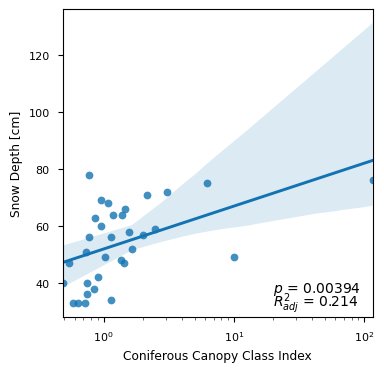

In [59]:
#Real data and Indicator 1 plot
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.regplot(data = diversityThree, x = 'PiInd', y = 'maxDepth',
            logx = True,
            ax = ax, color = pal[4])

#Do regression and add to plot
results = smf.ols('maxDepth ~ logPiInd', data = diversityThree).fit()
ax.text(20, 37, r'$ p $ = ' + str(round_sig(results.pvalues.logPiInd, 3)))
ax.text(20, 32, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax.set_xlabel('Coniferous Canopy Class Index')
ax.set_ylabel('Snow Depth [cm]')
ax.set_xlim(np.nanmin(diversityThree.PiInd), np.nanmax(diversityThree.PiInd))

ax.set_xscale('log')
plt.savefig(fig_savepath + 'DiversityIndex3-SnowDepth.pdf', bbox_inches = 'tight')

Just Upland Data

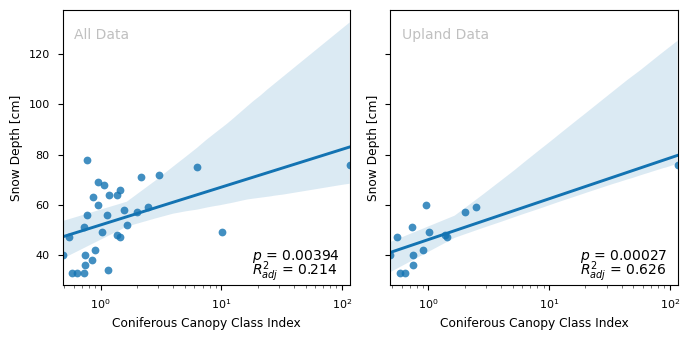

In [60]:
#Real data and Indicator 1 plot
fig, [ax2, ax] = plt.subplots(1, 2, figsize = (7, 3.5), 
                              layout = 'tight', 
                              sharex = True, 
                              sharey = True)

sns.regplot(data = diversityThree[diversityThree.zones == 'Upland'], x = 'PiInd', y = 'maxDepth',
            logx = True,
            ax = ax, color = pal[4])

#Do regression and add to plot
resultsUp = smf.ols('maxDepth ~ logPiInd', data = diversityThree[diversityThree.zones == 'Upland']).fit()
ax.text(18, 38, r'$ p $ = ' + str(round_sig(resultsUp.pvalues.logPiInd, 3)))
ax.text(18, 32, r'$ R_{adj}^2 $ = ' + str(round_sig(resultsUp.rsquared_adj, 3)))

ax.set_xlabel('Coniferous Canopy Class Index')
ax.set_ylabel('Snow Depth [cm]')
ax.set_xlim(np.nanmin(diversityThree.PiInd), np.nanmax(diversityThree.PiInd))

ax.set_xscale('log')
ax.text(0.6, 126, 'Upland Data', color = 'silver')

sns.regplot(data = diversityThree, x = 'PiInd', y = 'maxDepth',
            logx = True,
            ax = ax2, color = pal[4])

#Do regression and add to plot
results = smf.ols('maxDepth ~ logPiInd', data = diversityThree).fit()
ax2.text(18, 38, r'$ p $ = ' + str(round_sig(results.pvalues.logPiInd, 3)))
ax2.text(18, 32, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax2.set_xlabel('Coniferous Canopy Class Index')
ax2.set_ylabel('Snow Depth [cm]')
ax2.set_xlim(np.nanmin(diversityThree.PiInd), np.nanmax(diversityThree.PiInd))

ax2.set_xscale('log')
ax2.text(0.6, 126, 'All Data', color = 'silver')

plt.savefig(fig_savepath + 'DiversityIndex3-SnowDepth-upland.pdf', bbox_inches = 'tight')

In [61]:
resultsUp.params

Intercept    46.143894
logPiInd      7.056912
dtype: float64

#### Canopy Class Indicator #3 Melt Rates

In [62]:
#Subset and merge with snow data
diversityThreeMelt = pd.merge(meltData[['stakes', 'melt_meas', 'zones', 'watershed', 'aspect', 'slope', 'lai5ring', 'nTrees', 'pCon']], fs[['CCCon', 'pCo', 'SITE']], left_on = 'stakes', right_on = 'SITE', how = 'inner')
diversityThreeMelt = diversityThreeMelt.rename(columns = {diversityThreeMelt.columns[-3] : 'CCCon',
                                            diversityThreeMelt.columns[-2] : 'pCo', 
                                            diversityThreeMelt.columns[-1] : 'SITE'})
diversityThreeMelt.head()

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


,stakes,melt_meas,zones,watershed,aspect,slope,lai5ring,nTrees,pCon,CCCon,pCo,SITE
0,S200,328,Upland,S2,193.3626,6.632267,0.380709,12,0.000000,0.000000,0.583333,S200
1,S201,328,Upland,S2,115.0966,3.120716,0.403804,18,0.111111,0.222222,0.500000,S201
2,S203,321,Upland,S2,135.0012,7.452870,1.373774,16,0.437500,0.454545,0.687500,S203
3,S204,335,Upland,S2,254.4066,9.503919,1.750984,20,0.650000,0.625000,0.800000,S204
4,S205,328,Upland,S2,355.2919,3.051387,0.778448,14,0.142857,0.000000,0.214286,S205


In [63]:
#calculate non-dimensional variable
diversityThreeMelt['PiInd'] = diversityThreeMelt.pCon / (diversityThreeMelt.lai5ring*diversityThreeMelt.CCCon)
diversityThreeMelt['logPiInd'] = np.log(diversityThreeMelt['PiInd'])

#Change infs to nans
diversityThreeMelt = diversityThreeMelt.replace([np.inf, -np.inf], np.nan)
diversityThreeMelt.head()

,stakes,melt_meas,zones,watershed,aspect,slope,lai5ring,nTrees,pCon,CCCon,pCo,SITE,PiInd,logPiInd
0,S200,328,Upland,S2,193.3626,6.632267,0.380709,12,0.000000,0.000000,0.583333,S200,NaN,NaN
1,S201,328,Upland,S2,115.0966,3.120716,0.403804,18,0.111111,0.222222,0.500000,S201,1.238225,0.213679
2,S203,321,Upland,S2,135.0012,7.452870,1.373774,16,0.437500,0.454545,0.687500,S203,0.700625,-0.355783
3,S204,335,Upland,S2,254.4066,9.503919,1.750984,20,0.650000,0.625000,0.800000,S204,0.593952,-0.520957
4,S205,328,Upland,S2,355.2919,3.051387,0.778448,14,0.142857,0.000000,0.214286,S205,NaN,NaN


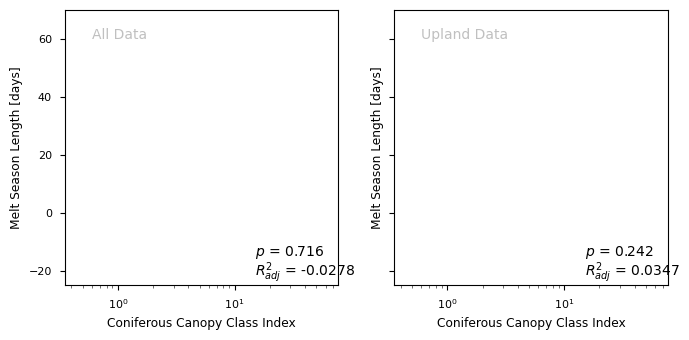

In [64]:
#Real data and Indicator 1 plot
fig, [ax2, ax] = plt.subplots(1, 2, figsize = (7, 3.5), 
                              layout = 'tight', 
                              sharex = True, 
                              sharey = True)

sns.regplot(data = diversityThreeMelt[diversityThreeMelt.zones == 'Upland'], x = 'PiInd', y = 'melt_meas',
            logx = True,
            ax = ax, color = pal[4])

#Do regression and add to plot
results = smf.ols('melt_meas ~ logPiInd', data = diversityThreeMelt[diversityThreeMelt.zones == 'Upland']).fit()
ax.text(15, -15, r'$ p $ = ' + str(round_sig(results.pvalues.logPiInd, 3)))
ax.text(15, -22, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax.set_xlabel('Coniferous Canopy Class Index')
ax.set_ylabel('Melt Season Length [days]')
ax.set_xlim(np.nanmin(diversityThreeMelt.PiInd), np.nanmax(diversityThreeMelt.PiInd))

ax.set_xscale('log')
ax.text(0.6, 60, 'Upland Data', color = 'silver')

sns.regplot(data = diversityThreeMelt, x = 'PiInd', y = 'melt_meas',
            logx = True,
            ax = ax2, color = pal[4])

#Do regression and add to plot
results = smf.ols('melt_meas ~ logPiInd', data = diversityThreeMelt).fit()
ax2.text(15, -15, r'$ p $ = ' + str(round_sig(results.pvalues.logPiInd, 3)))
ax2.text(15, -22, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax2.set_xlabel('Coniferous Canopy Class Index')
ax2.set_ylabel('Melt Season Length [days]')
ax2.set_xlim(np.nanmin(diversityThreeMelt.PiInd), np.nanmax(diversityThreeMelt.PiInd))
ax2.set_ylim(-25, 70)

ax2.set_xscale('log')
ax2.text(0.6, 60, 'All Data', color = 'silver')

plt.savefig(fig_savepath + 'DiversityIndex3-Melt-upland.pdf', bbox_inches = 'tight')

#### Canopy Class Indicator #3 Simulated

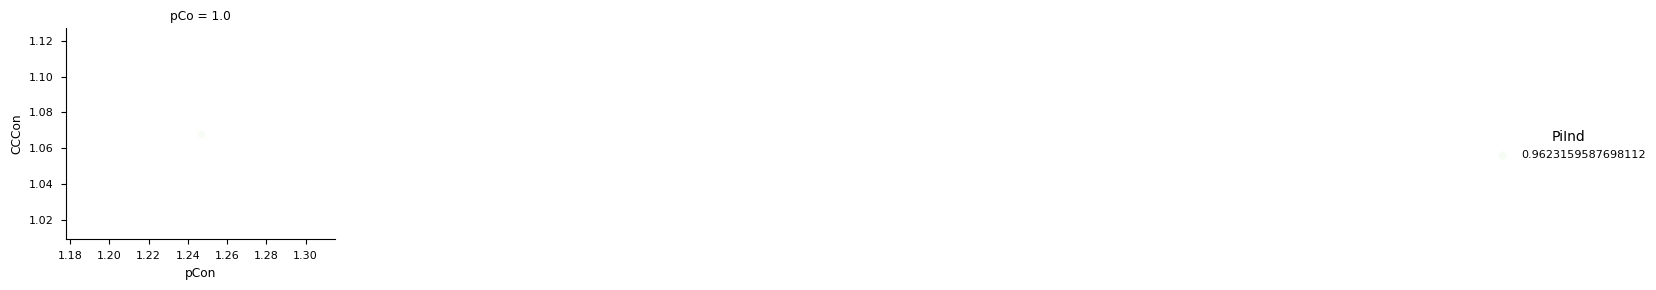

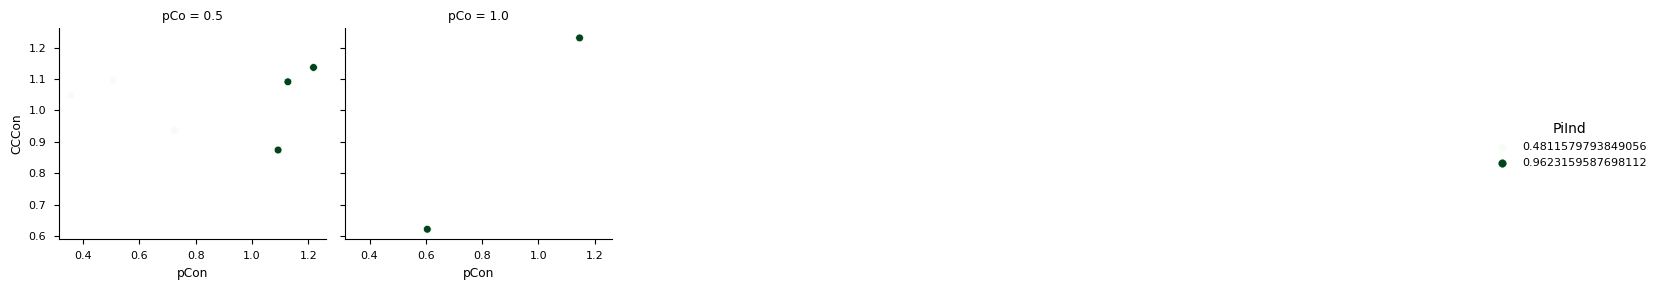

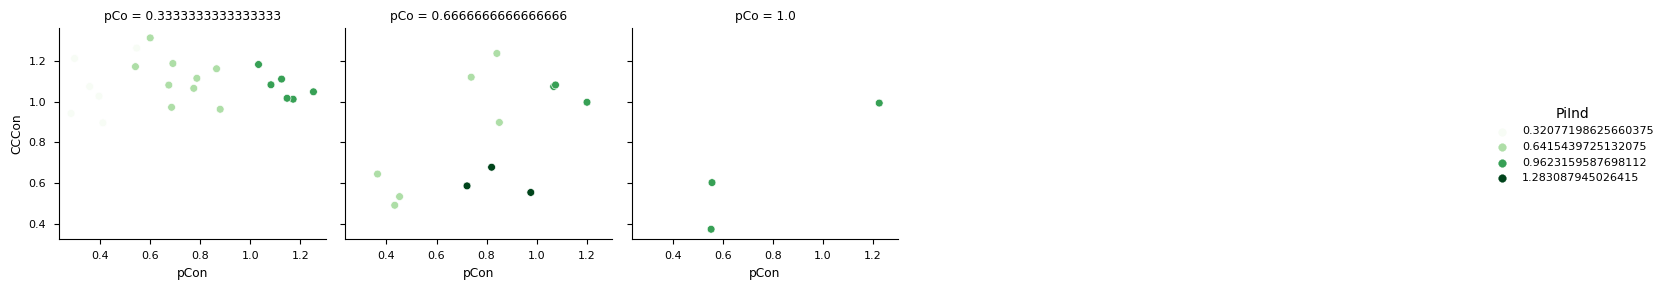

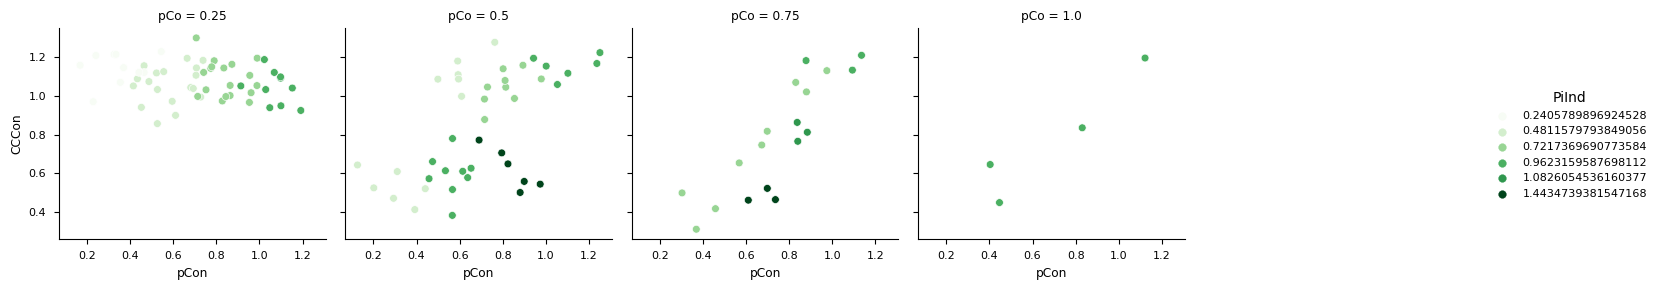

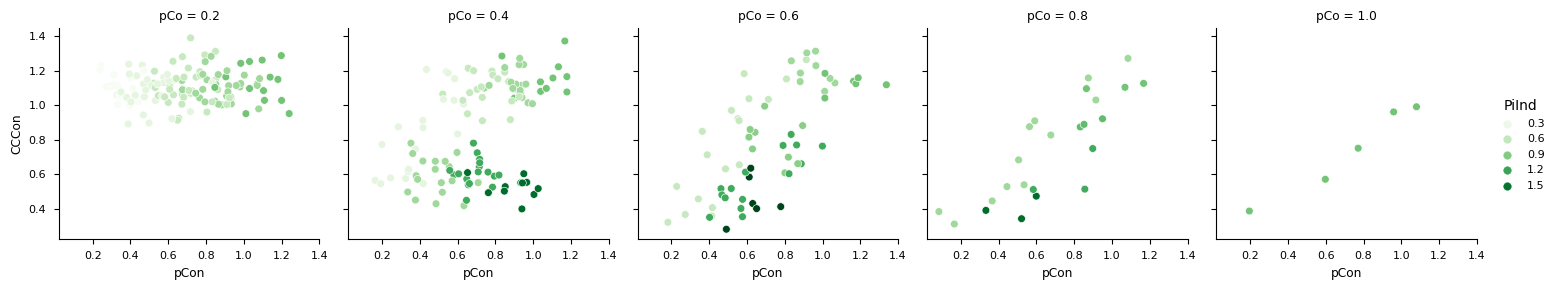

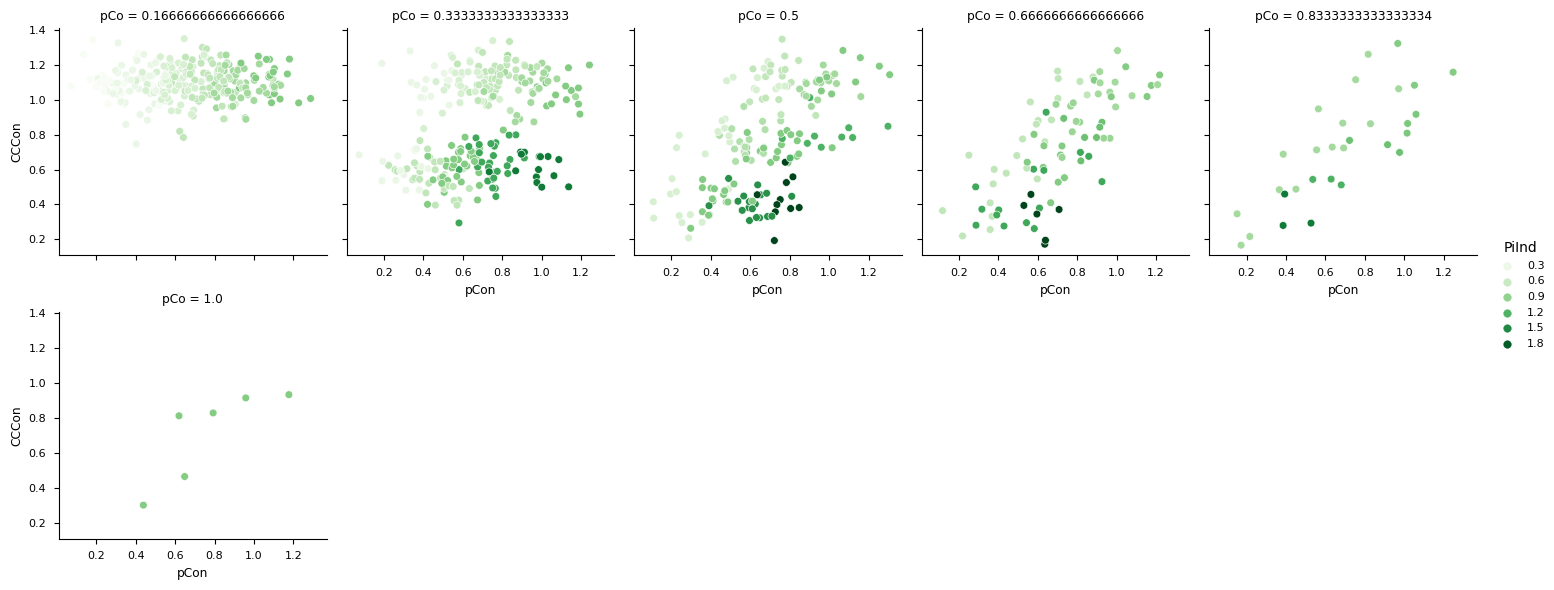

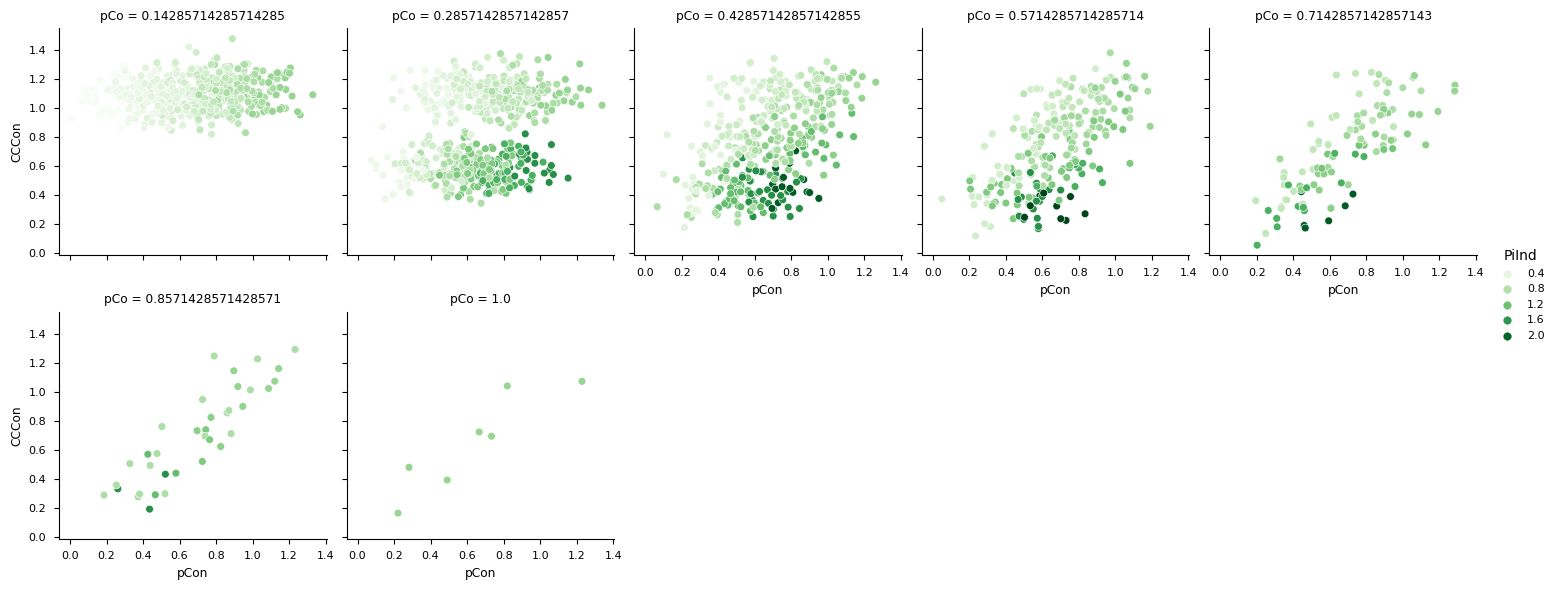

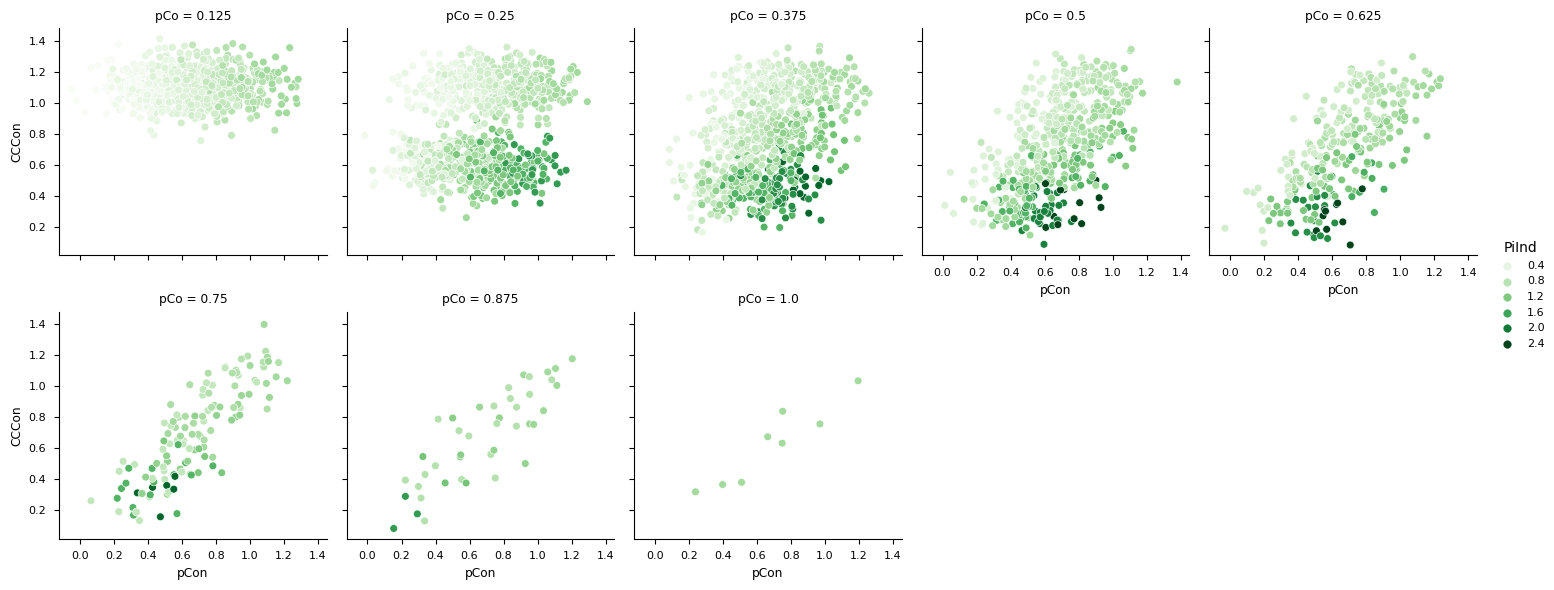

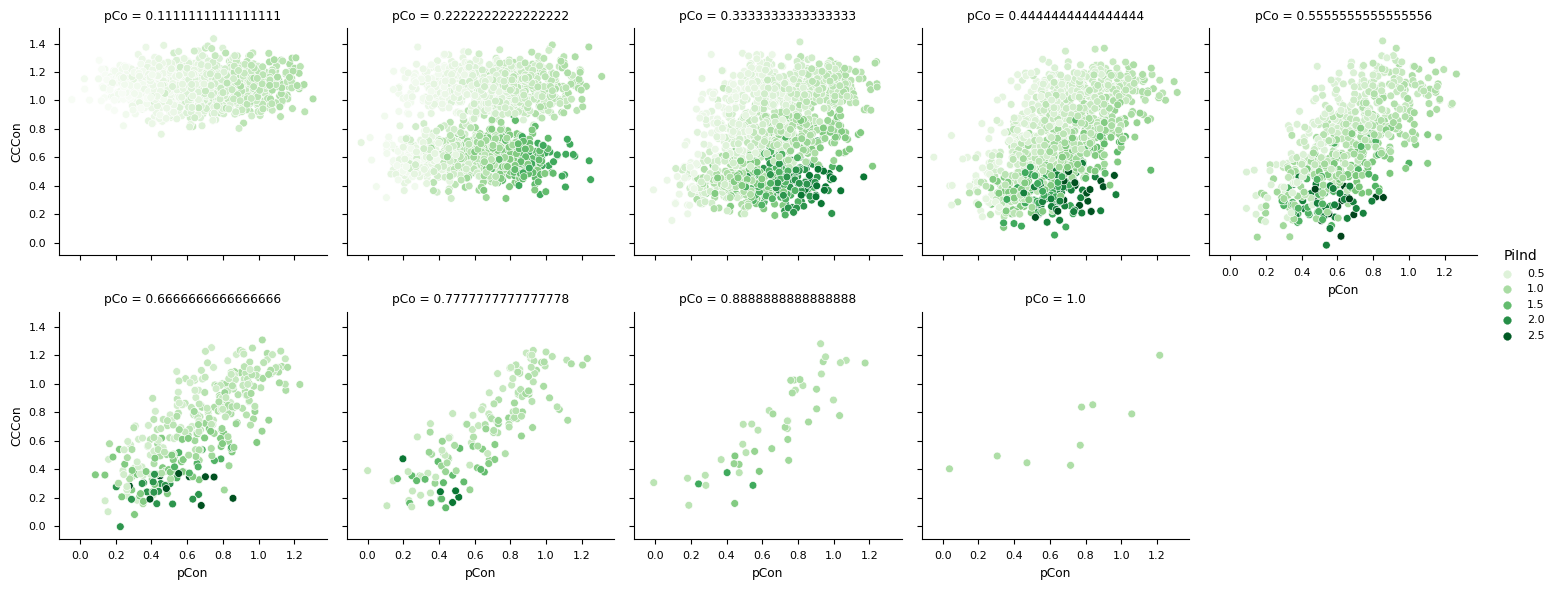

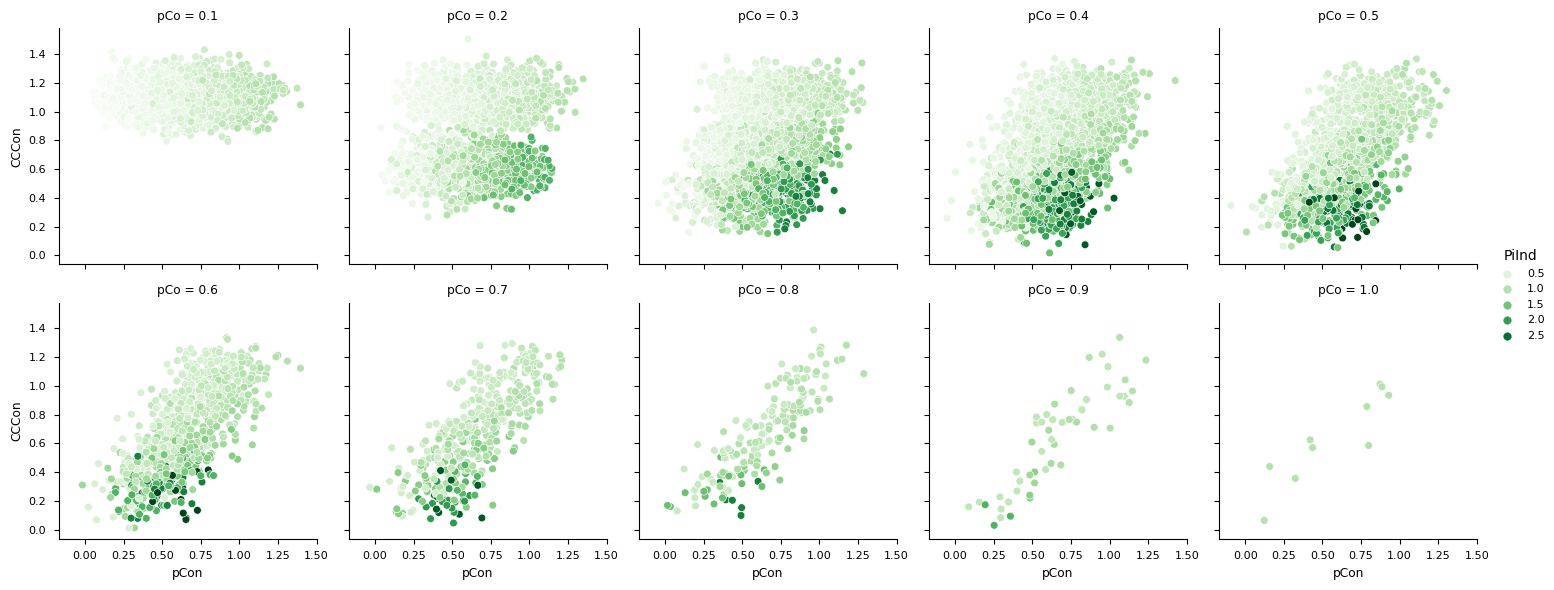

In [65]:
#Cycle through a select range of trees
for ntr in range(1, 11):
    #Numerical Representation of Metric
    Sup = []
    Int = []
    Co = []
    Dom = []
    SupCon = []
    IntCon = []
    CoCon = []
    DomCon = []

    #Generate fake data for a site
    nTrees = ntr

    for nSup in np.arange(0, nTrees + 1):
        for nInt in np.arange(0, nTrees + 1 - nSup):
            for nCo in np.arange(0, nTrees + 1 - nSup - nInt):
                nDom = nTrees - nSup - nInt - nCo

                for SupConif in np.arange(0, nSup + 1):
                    for IntConif in np.arange(0, nInt + 1):
                        for CoConif in np.arange(0, nCo + 1):
                            for DomConif in np.arange(0, nDom + 1):

                                #Save data
                                Sup.append(nSup)
                                Int.append(nInt)
                                Co.append(nCo)
                                Dom.append(nDom)

                                #Save data
                                SupCon.append(SupConif)
                                IntCon.append(IntConif)
                                CoCon.append(CoConif)
                                DomCon.append(DomConif)

    #Append into dataframe
    IndicatorData = pd.DataFrame({'Sup' : Sup, 
                            'Int' : Int, 
                            'Co' : Co, 
                            'Dom' : Dom,
                            'SupConif' : SupCon, 
                            'IntConif' : IntCon, 
                            'CoConif' : CoCon, 
                            'DomConif' : DomCon})

    #Compute Variables
    lai_test = np.nanmean(peakData.lai5ring)
    IndicatorData['CCCon'] = np.where(np.isnan((IndicatorData['CoConif']/IndicatorData['Co'])), 0, IndicatorData['CoConif']/IndicatorData['Co'])
    IndicatorData['pCon'] = (IndicatorData['CoConif'] + IndicatorData['DomConif'] + IndicatorData['IntConif'] + IndicatorData['SupConif'])/(IndicatorData['Co'] + IndicatorData['Dom'] + IndicatorData['Int'] + IndicatorData['Sup'])
    IndicatorData['pCo'] = IndicatorData['Co']/(IndicatorData['Co'] + IndicatorData['Dom'] + IndicatorData['Int'] + IndicatorData['Sup'])
    IndicatorData['PiInd'] = IndicatorData.pCon / (lai_test*IndicatorData.CCCon)

    #Change infs to nans
    IndicatorData = IndicatorData.replace([np.inf, -np.inf], np.nan)

    #Plot
    temp = IndicatorData[(IndicatorData.pCo > 0)]
    sns.relplot(data = temp, x = jitter(temp['pCon'], 0.1), y = jitter(temp['CCCon'], 0.1),
                hue = 'PiInd', palette = 'Greens', 
                col = 'pCo', col_wrap = 5, 
                height = 3, aspect = 1)

    plt.savefig(fig_savepath + 'simulationfigs/IndicatorModel_nTrees_' + str(ntr) + '.pdf', 
                bbox_inches = 'tight')


In [66]:
temp.head()

,Sup,Int,Co,Dom,SupConif,IntConif,CoConif,DomConif,CCCon,pCon,pCo,PiInd
11,0,0,1,9,0,0,0,0,0.0,0.0,0.1,NaN
12,0,0,1,9,0,0,0,1,0.0,0.1,0.1,NaN
13,0,0,1,9,0,0,0,2,0.0,0.2,0.1,NaN
14,0,0,1,9,0,0,0,3,0.0,0.3,0.1,NaN
15,0,0,1,9,0,0,0,4,0.0,0.4,0.1,NaN



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

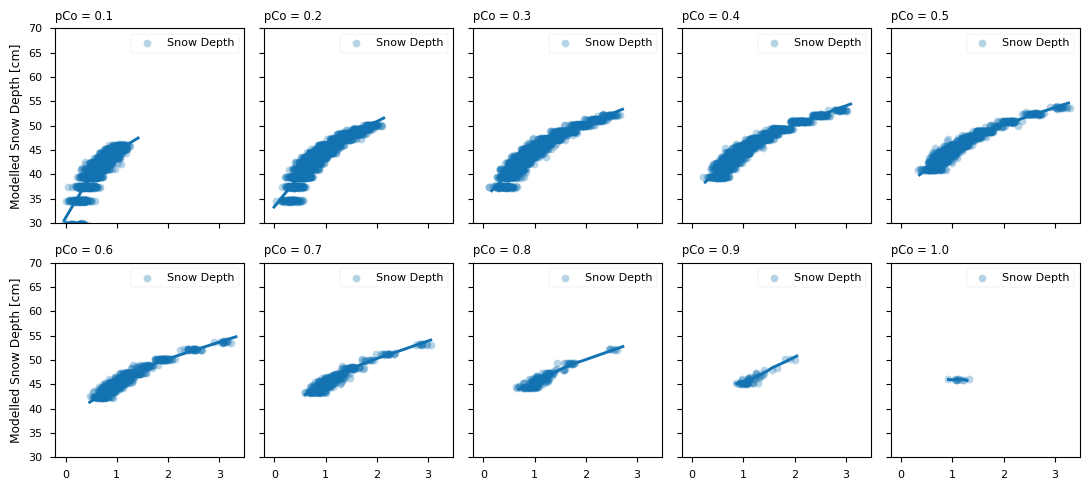

In [67]:
#simulations with uniform tree numbers (n = 10) and lai set to average of MEF sites
fig, axs = plt.subplots(2, 5, figsize = (11, 5), 
                        sharex = True, 
                        sharey = True, 
                        layout = 'tight')

co = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(0, 10):
    temp2 = temp[temp.pCo == co[i]]

    #Index Values
    yVal = temp2['pCon']/(temp2['CCCon'])
    
    #Model Snow Depth values
    temp2['SD'] = resultsUp.params.Intercept + resultsUp.params.logPiInd*np.log(temp2.PiInd)
    c = sns.scatterplot(data = temp2, x = jitter(yVal, 0.1), y = jitter(temp2['SD'], 0.1),
                color = pal[4], ax = axs.ravel()[i],
                linewidth = 0, alpha = 0.3, label = 'Snow Depth')
    d = sns.regplot(data = temp2, x = jitter(yVal, 0.1), y = jitter(temp2['SD'], 0.1),
                color = pal[4], ax = axs.ravel()[i],
                lowess = True, scatter = False)
    axs.ravel()[i].set_ylim(30, 70)

    #remove duplicate secondary y axes
    axs.ravel()[i].set_ylabel('Modelled Snow Depth [cm]')
        
    axs.ravel()[i].set_title('pCo = ' + str(co[i]), fontsize='small', loc='left')


plt.savefig(fig_savepath + 'DiversityIndex3-Simulations.pdf')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in multiply

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in multiply

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in multiply

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

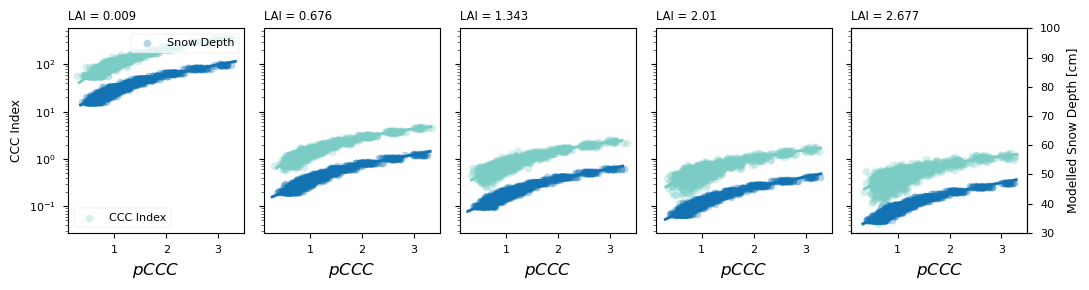

In [68]:
#simulations with uniform tree numbers (n = 10), pCo at 0.5, and a range of LAI
fig, axs = plt.subplots(1, 5, figsize = (11, 3), 
                        sharex = True, 
                        sharey = True, 
                        layout = 'tight')

co = 0.5
temp2 = temp[temp.pCo == co]
lai = np.linspace(start = np.nanmin(peakData.lai5ring), stop = np.nanmax(peakData.lai5ring), num = 5)

for i in range(0, 5):
    temp2.PiInd = temp2.pCon / (lai[i]*temp2.CCCon)
    yVal = temp2.pCon / (temp2.CCCon)

    #Index Values
    a = sns.scatterplot(data = temp2, x = jitter(yVal, 0.1), y = jitter(temp2['PiInd'], 0.1),
                color = pal[2], ax = axs.ravel()[i], 
                linewidth = 0, alpha = 0.3, label = 'CCC Index')
    b = sns.regplot(data = temp2, x = jitter(yVal, 0.1), y = jitter(temp2['PiInd'], 0.1),
                color = pal[2], ax = axs.ravel()[i], 
                lowess = True, scatter = False)
    
    #Model Snow Depth values
    temp2['SD'] = resultsUp.params.Intercept + resultsUp.params.logPiInd*np.log(temp2.PiInd)
    ax2 = axs.ravel()[i].twinx()
    c = sns.scatterplot(data = temp2, x = jitter(yVal, 0.1), y = jitter(temp2['SD'], 0.1),
                color = pal[4], ax = ax2,
                linewidth = 0, alpha = 0.3, label = 'Snow Depth')
    d = sns.regplot(data = temp2, x = jitter(yVal, 0.1), y = jitter(temp2['SD'], 0.1),
                color = pal[4], ax = ax2,
                lowess = True, scatter = False)
    ax2.set_ylim(30, 100)

    #remove duplicate secondary y axes
    if(i%5 != 4):
        ax2.set_axis_off()
    else:
        ax2.set_ylabel('Modelled Snow Depth [cm]')
        
    #add labels 
    if(i != 0):
        axs.ravel()[i].get_legend().remove()
        ax2.get_legend().remove()
    
    axs.ravel()[i].set_yscale('log')
    axs.ravel()[i].set_xlabel(r'$pCCC$', fontsize = 'large')
    axs.ravel()[i].set_ylabel('CCC Index')
    axs.ravel()[i].set_title('LAI = ' + str(round(lai[i], 3)), fontsize='small', loc='left')


plt.savefig(fig_savepath + 'DiversityIndex3-Simulations-varyLAI.pdf')

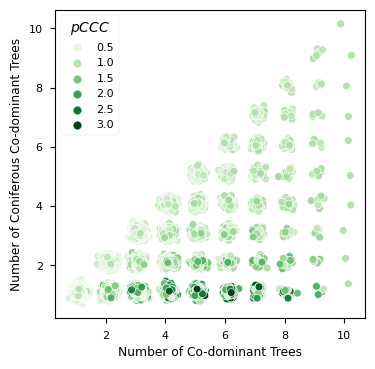

In [69]:
IndicatorData['pCCC'] = IndicatorData['pCon']/(IndicatorData['CCCon'])
IndicatorData = IndicatorData.replace([np.inf, -np.inf], np.nan)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.scatterplot(x = jitter(IndicatorData['Co'], 0.1), y = jitter(IndicatorData['CoConif'], 0.1),
                 hue = IndicatorData['pCCC'], palette = 'Greens', 
                 ax = ax)

ax.set_xlabel('Number of Co-dominant Trees')
ax.set_ylabel('Number of Coniferous Co-dominant Trees')
plt.legend(title = r'$pCCC}$')

plt.savefig(fig_savepath + "DiversityIndex3-Simulations-CCCfrac.pdf")

### Canopy Class Inidicator #4

In [70]:
dd.head()

,northing,easting,aspect,slope,maxDepth,lai5ring,avgDist_m,avgDBH_cm,sdDist_m,sdDBH_cm,...,nCo,nDom,nInt,nSup,pCon,pCoDom,H,S,S2,pCoDom2
0,464819.0,5262240.0,193.3626,6.632267,70.0,0.380709,5.354320,20.983333,1.290040,7.624701,...,7,2,3,0,0.000000,0.583333,0.959615,2.322581,5.394381,0.340278
1,464819.0,5262292.0,115.0966,3.120716,59.0,0.403804,4.480560,24.216667,1.604152,11.569547,...,9,3,6,0,0.111111,0.500000,1.011404,2.571429,6.612245,0.250000
2,464819.0,5262396.0,135.0012,7.452870,49.0,1.373774,5.025390,14.543750,1.841889,3.984632,...,11,3,2,0,0.437500,0.687500,0.831403,1.910448,3.649811,0.472656
3,464819.0,5262448.0,254.4066,9.503919,36.0,1.750984,5.486400,19.135000,1.786932,5.055302,...,16,0,4,0,0.650000,0.800000,0.500402,1.470588,2.162630,0.640000
4,464819.0,5262500.0,355.2919,3.051387,62.0,0.778448,5.614851,23.850000,1.514223,14.286613,...,3,4,4,3,0.142857,0.214286,1.376055,3.920000,15.366400,0.045918


(30.0, 82.0)

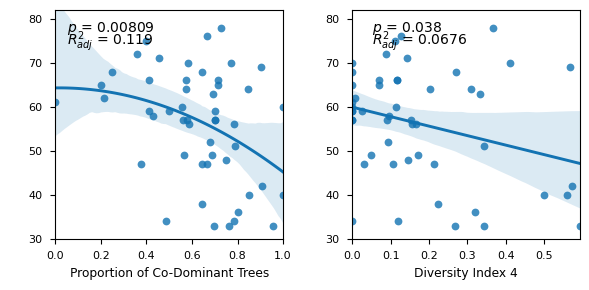

In [71]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (6, 3), 
                               layout = 'tight')

#Proportion of co-dominant trees
results3 = smf.ols('maxDepth ~ pCoDom2', data = dd).fit()
sns.regplot(x = dd.pCoDom, y = dd.maxDepth, order = 2, ax = ax1, color = pal[4])
ax1.text(0.05, 77, r'$ p $ = ' + str(round_sig(results3.pvalues.pCoDom2, 3)))
ax1.text(0.05, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results3.rsquared_adj, 3)))

ax1.set_xlabel('Proportion of Co-Dominant Trees')
ax1.set_ylabel(' ')
ax1.set_xlim(min(dd.pCoDom), max(dd.pCoDom))
ax1.set_ylim(30, 82)

#Diversity Index4
dd['CoH_Index'] = (np.log(dd.pCon + 1))*(dd.pCoDom2)
dd = dd.replace([np.inf, -np.inf], np.nan)
results3 = smf.ols('maxDepth ~ CoH_Index', data = dd).fit()
sns.regplot(x = dd.CoH_Index, y = dd.maxDepth, ax = ax2, color = pal[4])
ax2.text(0.05, 77, r'$ p $ = ' + str(round_sig(results3.pvalues.CoH_Index, 3)))
ax2.text(0.05, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results3.rsquared_adj, 3)))
#ax2.set_xscale('log')
ax2.set_xlabel('Diversity Index 4')
ax2.set_ylabel(' ')
ax2.set_xlim(np.nanmin(dd.CoH_Index), np.nanmax(dd.CoH_Index))
ax2.set_ylim(30, 82)

In [72]:
diversityFour = pd.merge(peakData[['stakes', 'maxDepth', 'zones', 'watershed', 'aspect', 'slope', 'lai5ring', 'nTrees', 'pCon']], fs[['CCCon', 'CCCon_ntrees', 'pCo', 'SITE']], left_on = 'stakes', right_on = 'SITE', how = 'inner')
diversityFour = diversityFour.rename(columns = {diversityFour.columns[-4] : 'CCCon',
                                            diversityFour.columns[-3] : 'CCCon_tree',
                                            diversityFour.columns[-2] : 'pCo', 
                                            diversityFour.columns[-1] : 'SITE'})
diversityFour.head()

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


,stakes,maxDepth,zones,watershed,aspect,slope,lai5ring,nTrees,pCon,CCCon,CCCon_tree,pCo,SITE
0,S200,70.0,Upland,S2,193.3626,6.632267,0.380709,12,0.000000,0.000000,0.000000,0.583333,S200
1,S201,59.0,Upland,S2,115.0966,3.120716,0.403804,18,0.111111,0.222222,0.111111,0.500000,S201
2,S203,49.0,Upland,S2,135.0012,7.452870,1.373774,16,0.437500,0.454545,0.312500,0.687500,S203
3,S204,36.0,Upland,S2,254.4066,9.503919,1.750984,20,0.650000,0.625000,0.500000,0.800000,S204
4,S205,62.0,Upland,S2,355.2919,3.051387,0.778448,14,0.142857,0.000000,0.000000,0.214286,S205


In [73]:
#calculate non-dimensional variable
diversityFour['Ind'] = (diversityFour.lai5ring*(np.sqrt(diversityFour.pCon))*(diversityFour.pCo*diversityFour.pCo))
diversityFour['IndLog'] = (diversityFour.lai5ring*(np.log(diversityFour.pCon + 1))*(diversityFour.pCo*diversityFour.pCo))

In [74]:
diversityFour.head()

,stakes,maxDepth,zones,watershed,aspect,slope,lai5ring,nTrees,pCon,CCCon,CCCon_tree,pCo,SITE,Ind,IndLog
0,S200,70.0,Upland,S2,193.3626,6.632267,0.380709,12,0.000000,0.000000,0.000000,0.583333,S200,0.000000,0.000000
1,S201,59.0,Upland,S2,115.0966,3.120716,0.403804,18,0.111111,0.222222,0.111111,0.500000,S201,0.033650,0.010636
2,S203,49.0,Upland,S2,135.0012,7.452870,1.373774,16,0.437500,0.454545,0.312500,0.687500,S203,0.429487,0.235643
3,S204,36.0,Upland,S2,254.4066,9.503919,1.750984,20,0.650000,0.625000,0.500000,0.800000,S204,0.903481,0.561184
4,S205,62.0,Upland,S2,355.2919,3.051387,0.778448,14,0.142857,0.000000,0.000000,0.214286,S205,0.013510,0.004773


## Index Summary


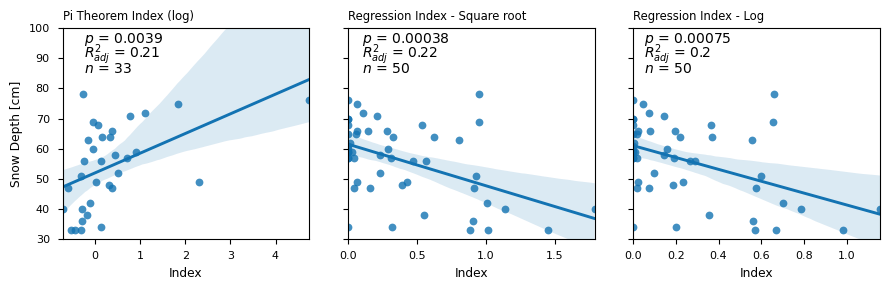

In [75]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                             sharey = True, 
                                             layout = 'tight')

sns.regplot(data = diversityThree, x = 'logPiInd', y = 'maxDepth', 
            ax = ax1, 
            color = pal[4])
results1 = smf.ols('maxDepth ~ logPiInd', data = diversityThree).fit()
ax1.set_xlim(np.nanmin(diversityThree.logPiInd), np.nanmax(diversityThree.logPiInd))
ax1.text(-0.25, 95, r'$ p $ = ' + str(round_sig(results1.pvalues.logPiInd, 2)))
ax1.text(-0.25, 90, r'$ R_{adj}^2 $ = ' + str(round_sig(results1.rsquared_adj, 2)))
ax1.text(-0.25, 85, r'$ n $ = ' + str(len(results1.fittedvalues)))
ax1.set_xlabel('Index')
ax1.set_ylabel('Snow Depth [cm]')
ax1.set_title('Pi Theorem Index (log)', fontsize='small', loc='left')

sns.regplot(data = diversityFour, x = 'Ind', y = 'maxDepth', 
            ax = ax2, 
            color = pal[4])
results2 = smf.ols('maxDepth ~ Ind', data = diversityFour).fit()
ax2.text(0.1, 95, r'$ p $ = ' + str(round_sig(results2.pvalues.Ind, 2)))
ax2.text(0.1, 90, r'$ R_{adj}^2 $ = ' + str(round_sig(results2.rsquared_adj, 2)))
ax2.text(0.1, 85, r'$ n $ = ' + str(len(results2.fittedvalues)))
ax2.set_xlim(np.nanmin(diversityFour.Ind), np.nanmax(diversityFour.Ind))
ax2.set_ylabel(' ')
ax2.set_xlabel('Index')
ax2.set_title('Regression Index - Square root', fontsize='small', loc='left')

sns.regplot(data = diversityFour, x = 'IndLog', y = 'maxDepth', 
            ax = ax3, 
            color = pal[4])
results3 = smf.ols('maxDepth ~ IndLog', data = diversityFour).fit()
ax3.text(0.05, 95, r'$ p $ = ' + str(round_sig(results3.pvalues.IndLog, 2)))
ax3.text(0.05, 90, r'$ R_{adj}^2 $ = ' + str(round_sig(results3.rsquared_adj, 2)))
ax3.text(0.05, 85, r'$ n $ = ' + str(len(results3.fittedvalues)))
ax3.set_xlim(np.nanmin(diversityFour.IndLog), np.nanmax(diversityFour.IndLog))
ax3.set_ylabel(' ')
ax3.set_xlabel('Index')
ax3.set_title('Regression Index - Log', fontsize='small', loc='left')

ax1.set_ylim(30, 100)

plt.savefig(fig_savepath + 'index_summary.pdf')


What this says to me is that snow depth is more dependent on the interaction of LAI and tree structure in dense coniferous canopies -- whereas LAI is a perfectly fine predictor in deciduous canopies.

LAI breakdown:

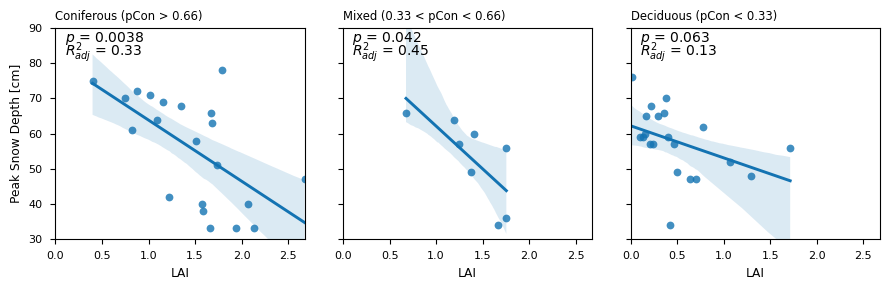

In [76]:
#Prep Data
bins = list(np.linspace(np.nanmin(diversityFour.pCon), np.nanmax(diversityFour.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
diversityFour['Bin'] = pd.cut(diversityFour['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')

sns.regplot(data = diversityFour[diversityFour.Bin == 'Dense Coniferous'], x = 'lai5ring', y = 'maxDepth', 
            ax = ax1, 
            color = pal[4])
resultsDenseCon = smf.ols('maxDepth ~ lai5ring', data = diversityFour[diversityFour.Bin == 'Dense Coniferous']).fit()
ax1.text(0.1, 86, r'$ p $ = ' + str(round_sig(resultsDenseCon.pvalues.lai5ring, 2)))
ax1.text(0.1, 82, r'$ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon.rsquared_adj, 2)))
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('LAI')

sns.regplot(data = diversityFour[diversityFour.Bin == 'Mixed'], x = 'lai5ring', y = 'maxDepth', 
            ax = ax2, 
            color = pal[4])
resultsMixed = smf.ols('maxDepth ~ lai5ring', data = diversityFour[diversityFour.Bin == 'Mixed']).fit()
ax2.text(0.1, 86, r'$ p $ = ' + str(round_sig(resultsMixed.pvalues.lai5ring, 2)))
ax2.text(0.1, 82, r'$ R_{adj}^2 $ = ' + str(round_sig(resultsMixed.rsquared_adj, 2)))
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('LAI')

sns.regplot(data = diversityFour[diversityFour.Bin == 'Dense Deciduous'], x = 'lai5ring', y = 'maxDepth', 
            ax = ax3, 
            color = pal[4])
resultsDenseDec = smf.ols('maxDepth ~ lai5ring', data = diversityFour[diversityFour.Bin == 'Dense Deciduous']).fit()
ax3.text(0.1, 86, r'$ p $ = ' + str(round_sig(resultsDenseDec.pvalues.lai5ring, 2)))
ax3.text(0.1, 82, r'$ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec.rsquared_adj, 2)))
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('LAI')

ax1.set_xlim(0, max(diversityFour.lai5ring))
ax1.set_ylim(30, 90)

plt.savefig(fig_savepath + 'covertype_lairegression.pdf')

## Soil Moisture and Drydown 

In [77]:
#Import Drydown data
drydown = pd.read_csv(import_path + 'soilMoisture_Drawdown.csv')
drydown.head()

,Unnamed: 0,Site,Depth,BeginDate,BeginDOY,BeginAmt,EndDate,EndDOY,EndAmt,Length,Drawdown
0,0,S603,15cm,2023-07-26 07:00:00,207,33.3,2023-09-23 00:00:00,266,13.3,58,20.0
1,1,S603,30cm,2023-07-26 08:00:00,207,36.4,2023-09-23 00:00:00,266,19.0,58,17.4
2,2,S603,45cm,2023-05-07 21:00:00,127,36.4,2023-09-23 01:00:00,266,13.3,138,23.1
3,3,S613,15cm,2023-05-20 01:00:00,140,24.5,2023-09-23 00:00:00,266,10.0,125,14.5
4,4,S613,30cm,2023-04-18 13:00:00,108,36.3,2023-09-24 01:00:00,267,9.7,158,26.6


In [78]:
#Merge with veg data and the regression index data
drydown_veg = pd.merge(drydown, diversityFour, right_on = 'SITE', left_on = 'Site', how = 'inner')
drydown_veg.head()

,Unnamed: 0,Site,Depth,BeginDate,BeginDOY,BeginAmt,EndDate,EndDOY,EndAmt,Length,...,lai5ring,nTrees,pCon,CCCon,CCCon_tree,pCo,SITE,Ind,IndLog,Bin
0,0,S603,15cm,2023-07-26 07:00:00,207,33.3,2023-09-23 00:00:00,266,13.3,58,...,1.938306,21,0.809524,0.937500,0.714286,0.761905,S603,1.012368,0.667306,Dense Coniferous
1,1,S603,30cm,2023-07-26 08:00:00,207,36.4,2023-09-23 00:00:00,266,19.0,58,...,1.938306,21,0.809524,0.937500,0.714286,0.761905,S603,1.012368,0.667306,Dense Coniferous
2,2,S603,45cm,2023-05-07 21:00:00,127,36.4,2023-09-23 01:00:00,266,13.3,138,...,1.938306,21,0.809524,0.937500,0.714286,0.761905,S603,1.012368,0.667306,Dense Coniferous
3,3,S613,15cm,2023-05-20 01:00:00,140,24.5,2023-09-23 00:00:00,266,10.0,125,...,1.753550,29,0.620690,0.529412,0.310345,0.586207,S613,0.474742,0.290960,Mixed
4,4,S613,30cm,2023-04-18 13:00:00,108,36.3,2023-09-24 01:00:00,267,9.7,158,...,1.753550,29,0.620690,0.529412,0.310345,0.586207,S613,0.474742,0.290960,Mixed


Text(0, 0.5, 'End of Summer Soil Moisture [cm3/cm3]')

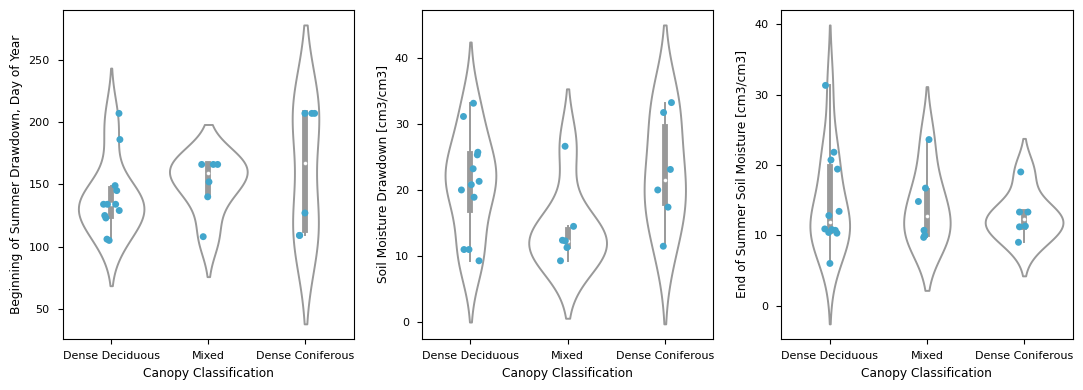

In [82]:
fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize = (11, 4), 
                            sharex = True, 
                            layout = 'tight')

sns.violinplot(data = drydown_veg, x = 'Bin', y = 'BeginDOY',
            color = 'white', ax = ax)
sns.stripplot(data = drydown_veg, x = 'Bin', y = 'BeginDOY',
            color = pal[3], ax = ax,
            zorder = 4)
ax.set_xlabel('Canopy Classification')
ax.set_ylabel('Beginning of Summer Drawdown, Day of Year')

sns.violinplot(data = drydown_veg, x = 'Bin', y = 'Drawdown',
            color = 'white', ax = ax2)
sns.stripplot(data = drydown_veg, x = 'Bin', y = 'Drawdown',
            color = pal[3], ax = ax2,
            zorder = 4)
ax2.set_xlabel('Canopy Classification')
ax2.set_ylabel('Soil Moisture Drawdown [cm3/cm3]')

sns.violinplot(data = drydown_veg, x = 'Bin', y = 'EndAmt',
            color = 'white', ax = ax3)
sns.stripplot(data = drydown_veg, x = 'Bin', y = 'EndAmt',
            color = pal[3], ax = ax3,
            zorder = 4)
ax3.set_xlabel('Canopy Classification')
ax3.set_ylabel('End of Summer Soil Moisture [cm3/cm3]')
